In [47]:
import matplotlib.pyplot as plt
from colour import Color
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import subprocess as S
import shutil 
from decimal import Decimal
import Krunchmanday 

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

sns.set()
sns.set_style("whitegrid")
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('grid', linestyle = '--', alpha = 0.2)     # grid
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

MWs = {'Na+':22.98,
         'K+':39,
         'Ca++':40.08,
         'Mg++':24.3,
         'SiO2(aq)': 28}

-------------------------------------------------------------------

# Batch experimental and modeling results

In [5]:
#Read batch experiments results
batch_exp_df = pd.read_csv('../HydroShare_repo/BatchExperimentCations.csv')

#Read batch modeling results
domains = ['Deep', 'Middle', 'Shallow']
Best_fits_dict = {'Shallow':'Shallow_Cuttings_batch',
                 'Middle':'Middle_Cuttings_batch',
                  'Deep':'Deep_Cuttings_batch'
                 }
working_folder = '../GitHub_Zenodo_repo/Batch_Experiments_Model/'

BK_dict = []
for domain in domains:
    case_name = Best_fits_dict[domain]
    BK_df = Krunchmanday.compile_sim_output(working_folder, case_name)
    BK_dict.append(BK_df)
BK_dict = dict(zip(domains, BK_dict))

Plot batch best fitting model along with experimental results

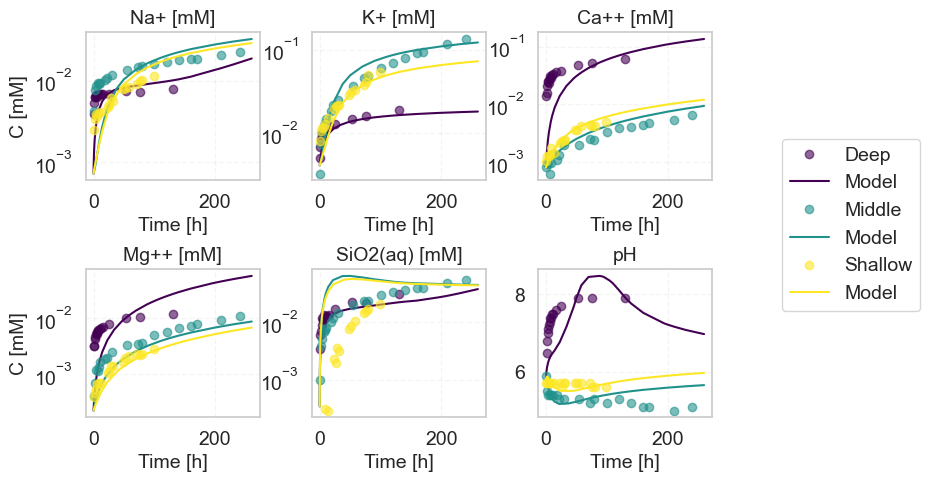

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(11, 5))
gs = GridSpec(2, 4, figure=fig, wspace=0.3, hspace=0.6)

axs = [fig.add_subplot(gs[i // 3, i % 3]) for i in range(6)]  
colors = Krunchmanday.create_color_list(domains, 'viridis')
spes = ['Na_mM', 'K_mM', 'Ca_mM', 'Mg_mM', 'Si_mM', 'pH']
labels = ['Na+', 'K+', 'Ca++', 'Mg++', 'SiO2(aq)', 'pH']

for spe, label, ax in zip(spes, labels, axs):
    for domain, color in zip(domains, colors):
        df_aux = BK_dict[domain]
        df_batch = batch_exp_df.loc[batch_exp_df.Group == domain]
        ax.plot(df_batch['Cum_hours'], df_batch[spe], marker='o', linestyle='', color=color, alpha=0.6, label=domain)
        if spe == 'pH':
            ax.plot(df_aux['time'], df_aux[spe], color=color, label='Model')
            ax.set(yscale='linear', title=spe, xlabel='Time [h]')
        else:
            ax.plot(df_aux['time'], df_aux[label] * 1000, color=color, label='Model')
            ax.set(yscale='log', title=f'{label} [mM]', xlabel='Time [h]')

axs[0].set_ylabel('C [mM]')
axs[3].set_ylabel('C [mM]')
ax_legend = fig.add_subplot(gs[:, 3]) 
ax_legend.axis('off')  

handles, labels = axs[0].get_legend_handles_labels()  
ax_legend.legend(handles, labels, loc='center')
plt.show()

# VMS field data

Compare data from VMS ports type A and B to show they are consistent

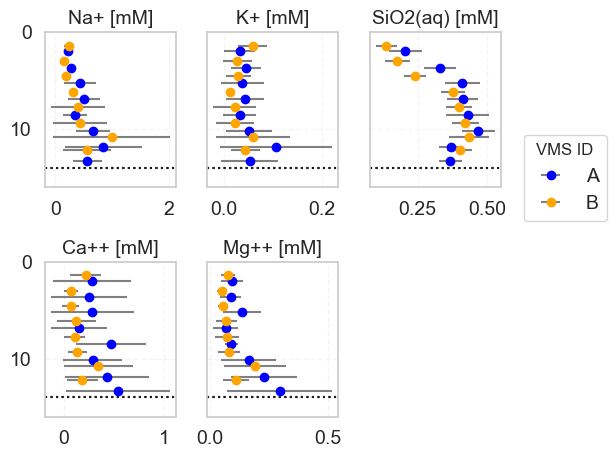

In [13]:
depth_watertable = 14 #meters
vms_field_df = pd.read_csv('../HydroShare_repo/Cations_Master.csv')

fig, axs = plt.subplots(2,3, sharey = True, sharex = False)
for VMS_choice, color in zip(['A', 'B'], ['blue', 'orange']):
    aux_chem = vms_field_df.loc[vms_field_df.port_ID.str.contains(VMS_choice)]
    df_aux = Krunchmanday.build_VMS_df(aux_chem, 2016)
    df_aux = df_aux.loc[df_aux.Distance < depth_watertable]
    for spe, colrow in zip(['Na+', 'K+', 'Ca++', 'Mg++', 'SiO2(aq)'], 
                      [[0,0], [0,1], [1,0], [1,1], [0,2]]):
        ax = axs[colrow[0], colrow[1]]
        ax.errorbar(x = df_aux[spe]['mean'], y = df_aux['Distance'], xerr = df_aux[spe]['std'],
                    fmt = 'o', ecolor = 'grey', label = VMS_choice, color = color)
        ax.set(title = f'{spe} [mM]', ylim = (16,0))
        ax.axhline(y = 14, linestyle = ':', color = 'k')
axs[1,2].set_axis_off()
ax.legend(bbox_to_anchor = (1.1,0.4), loc = 2, title = 'VMS ID')
fig.tight_layout()
plt.show()

Compute fluxes from VMS field data

Keep working only with A-type VMS ports and Remove outliers from dataset

In [17]:
variables = ['Ca_mM', 'Mg_mM', 'K_mM', 'Na_mM', 'Si_mM']
# Uniformize data
vms_field_df = vms_field_df.loc[vms_field_df.port_ID.str.contains('A')]
vms_field_df = vms_field_df.loc[:,['port_ID', 'Depth_m', 'Date', 'year', 'month']+variables]
vms_field_df = vms_field_df.loc[(vms_field_df.year < 2020)]

# Define variables of interest
variables = ['Ca_mM', 'Mg_mM', 'K_mM', 'Na_mM', 'Si_mM']

# Create an empty DataFrame to store cleaned data
vms_field_df_long = pd.DataFrame()

# Remove outliers for each variable and port ID
for spe in variables:
    for port_id in vms_field_df['port_ID'].unique():
        filtered_data = Krunchmanday.remove_outliers(
            vms_field_df.loc[vms_field_df['port_ID'] == port_id, ['port_ID', 'Depth_m', 'Date', 'year', 'month', spe]], 
            spe
        )
        filtered_data['spe'] = spe  # Add 'spe' column to indicate the variable
        filtered_data.columns = ['port_ID', 'Depth_m', 'Date', 'year', 'month', 'value', 'spe']
        vms_field_df_long = pd.concat([vms_field_df_long, filtered_data])

# Pivot the cleaned data
vms_field_df_short = vms_field_df_long.pivot_table(
    index=['port_ID', 'Depth_m', 'Date', 'year', 'month'],  
    columns='spe',  
    values='value',  
    aggfunc='first'  
).reset_index()

Compute chemical weathering fluxes from VMS data

In [21]:
start_year = 2016 
rain_source = 'RW'
Flow_std = 0.40 #m/yr from 2016-2020 weather data
Avg_F_CW_kim = 163.0 #ton/m2/yr --> this value is comparable with mine, from my excel file FluxesVerification.xlsx
Avg_F_creek_kim = 118.7
print(f'### Mass Fluxes from {start_year}-2020 ###\n---> (SiO2 as Si to compary with Kim) <---\n--------------')

Aqueous_input = pd.read_csv('../HydroShare_repo/RainfallChemistry.csv')

df_aux = Krunchmanday.build_VMS_df(vms_field_df_short, start_year)
df_aux = df_aux.loc[df_aux.Distance < depth_watertable]

Darcy_Flow = 1.7 #m/y Range computed from P-ET data
flux_Ca_field =((df_aux['Ca++'].iloc[-1]['mean']/1000- #mM to mol/L
                 float(Aqueous_input.loc[Aqueous_input.Var == 'Ca++', rain_source].values[0]))# mol/L
                 *40#g/mol -> atomic mass
                 *1000)# L/m3
flux_Mg_field = (df_aux['Mg++'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Mg++', rain_source].values[0]))*24.3*1000
flux_Na_field = (df_aux['Na+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Na+', rain_source].values[0]))*22.98*1000
flux_K_field = (df_aux['K+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'K+', rain_source].values[0]))*39.09*1000
flux_Si_field = (df_aux['SiO2(aq)'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'SiO2(aq)', rain_source].values[0]))*(28)*1000

Delta_C = 1000*((df_aux['Ca++'].iloc[-1]['mean']/1000-float(Aqueous_input.loc[Aqueous_input.Var == 'Ca++', rain_source].values[0]))*40 +\
            (df_aux['Mg++'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Mg++', rain_source].values[0]))*24.3 +\
            (df_aux['Na+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'Na+', rain_source].values[0]))*22.98 +\
            (df_aux['K+'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'K+', rain_source].values[0]))*39.09 +\
            (df_aux['SiO2(aq)'].iloc[-1]['mean']/1000 - float(Aqueous_input.loc[Aqueous_input.Var == 'SiO2(aq)', rain_source].values[0]))*(28))

Std_sumC_field = np.sqrt(
                (df_aux['Ca++'].iloc[-1]['std']*40)**2 + 
                (df_aux['Mg++'].iloc[-1]['std']*24.3)**2 + 
                (df_aux['Na+'].iloc[-1]['std']*22.98)**2 +
                (df_aux['K+'].iloc[-1]['std']*39.09)**2 +
                (df_aux['SiO2(aq)'].iloc[-1]['std']*(28))**2)

sumC = flux_Ca_field + flux_Mg_field + flux_Na_field + flux_K_field + flux_Si_field
Flux_field = sumC * Darcy_Flow 
Std_Flux_field = Flux_field*np.sqrt((Std_sumC_field/sumC)**2+
                                   (Flow_std/Darcy_Flow)**2)
VZ_fraction_to_F_CW = 100*Flux_field/Avg_F_CW_kim
VZ_fraction_to_creek = 100*Flux_field/Avg_F_creek_kim
print(f'for A-type VMS ports & Drainage {Darcy_Flow} m/y:') 
print(f'Delta C = {Delta_C:.1f} mg\L')
print(f'total flux = {Flux_field:.1f} +/- {Std_Flux_field:.1f} g/m2/yr (or ton/km2/yr)')
print(f'VZ estimate represents {VZ_fraction_to_F_CW:.1f}% of the total chemical flux')
print(f'and represents {VZ_fraction_to_creek:.1f}% of the chemical flux in Elder Creek')

### Mass Fluxes from 2016-2020 ###
---> (SiO2 as Si to compary with Kim) <---
--------------
for A-type VMS ports & Drainage 1.7 m/y:
Delta C = 47.6 mg\L
total flux = 80.9 +/- 34.2 g/m2/yr (or ton/km2/yr)
VZ estimate represents 49.6% of the total chemical flux
and represents 68.1% of the chemical flux in Elder Creek


In [25]:
print('### How concentrations change in milliequivalents ###\n--------------')

df_aux = Krunchmanday.build_VMS_df(vms_field_df_short, 2016)
df_aux = df_aux.loc[df_aux.Distance < depth_watertable]

for loc, label in zip([0, -1], ['top', 'bottom']):
    total_conc = 0  # To accumulate total concentration at each location
    total_std = 0
    for spe, eq in zip(['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)'], [2, 2, 1, 1, 1]):
        conc = df_aux[spe].iloc[loc]['mean'] * MWs[spe]   # mg/L
        std = df_aux[spe].iloc[loc]['std'] * MWs[spe]  # mg/L
        total_conc += conc
        total_std += std**2
        if spe == 'SiO2(aq)':
            print(f'{spe} at {label} = {conc:.1f} +- {std:.1f} mg/L\n')# meq/L\n')
        else:
            print(f'{spe} at {label} = {conc:.1f} +- {std:.1f} mg/L')# meq/L')

    total_std = np.sqrt(total_std)
    print(f'Total concentration at {label} of VMS = {total_conc:.1f} +- {total_std:.1f} mg/L\n')# meq/L\n')


### How concentrations change in milliequivalents ###
--------------
Ca++ at top = 4.5 +- 1.6 mg/L
Mg++ at top = 1.8 +- 0.3 mg/L
Na+ at top = 4.8 +- 0.9 mg/L
K+ at top = 1.0 +- 0.3 mg/L
SiO2(aq) at top = 5.3 +- 1.0 mg/L

Total concentration at top of VMS = 17.4 +- 2.1 mg/L

Ca++ at bottom = 19.2 +- 16.0 mg/L
Mg++ at bottom = 6.6 +- 4.1 mg/L
Na+ at bottom = 10.4 +- 2.5 mg/L
K+ at bottom = 1.5 +- 0.3 mg/L
SiO2(aq) at bottom = 10.2 +- 0.9 mg/L

Total concentration at bottom of VMS = 47.9 +- 16.7 mg/L



In [27]:
df_vms = Krunchmanday.build_VMS_df(vms_field_df_short, 2016)
df_vms = df_vms.loc[df_vms.Distance < depth_watertable]

# Lists to store results
results = []
depth_means = []  # Store weighted mean concentrations for each depth

for loc in df_vms.Distance.unique():
    means, stds, weights = [], [], []

    # Iterate over cations and compute weighted stats
    for spe, eq in zip(['Ca++', 'Mg++', 'Na+', 'K+', 'SiO2(aq)'], [2, 2, 1, 1, 1]):
        conc_mean = df_vms.loc[df_vms.Distance == loc, spe]['mean'].values[0] * MWs[spe]
        conc_std = df_vms.loc[df_vms.Distance == loc, spe]['std'].values[0] * MWs[spe]

        means.append(conc_mean)
        stds.append(conc_std)
        weights.append(1 / conc_std**2 if conc_std > 0 else 0)

    # Compute weighted mean & std dev
    weights_sum = sum(weights)
    normalized_weights = [w / weights_sum for w in weights] if weights_sum > 0 else [0] * len(weights)
    
    weighted_mean = sum(w * m for w, m in zip(normalized_weights, means))
    weighted_variance = sum(w * (s ** 2) for w, s in zip(normalized_weights, stds))
    weighted_std = np.sqrt(weighted_variance)

    # Compute Relative Standard Deviation (RSD)
    rsd = (weighted_std / weighted_mean) * 100 if weighted_mean != 0 else 0

    # Store results
    results.append([loc, weighted_mean, weighted_std, rsd])
    depth_means.append(weighted_mean)  # Store for XX% RSD calculation

# Create DataFrame for tabular output
df_results = pd.DataFrame(results, columns=['Depth (m)', 'Weighted Mean (mg/L)', 'Weighted StdDev (mg/L)', 'RSD (%)'])
df_results.set_index('Depth (m)', inplace=True)

# Compute overall statistics
average_rsd = np.mean([r for r in df_results['RSD (%)'] if not np.isnan(r)])
average_std = np.mean([s for s in df_results['Weighted StdDev (mg/L)'] if not np.isnan(s)])

# Compute XX% RSD based on depth_means (Fix)
if depth_means:
    overall_mean = np.mean(depth_means)
    overall_std = np.std(depth_means)
    xx_rsd = (overall_std / overall_mean) * 100 if overall_mean != 0 else 0
else:
    xx_rsd = np.nan  # No valid means

# Display table
print(df_results)

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average RSD across depths (YY%): {average_rsd:.0f}%")
print(f"Average Std Dev across depths: {average_std:.1f} mg/L")
print(f"RSD of mean concentrations across depths (XX%): {xx_rsd:.0f}%")  # Fixed computation

           Weighted Mean (mg/L)  Weighted StdDev (mg/L)    RSD (%)
Depth (m)                                                         
1.95                   1.765874                0.455829  25.813235
3.64                   2.220234                0.619290  27.893022
5.22                   1.646414                0.478648  29.072158
6.88                   1.861086                0.648276  34.833215
8.49                   1.514755                0.433792  28.637740
10.16                  3.256815                0.879407  27.002067
11.89                  7.462682                1.624148  21.763601
13.33                  2.533686                0.648829  25.608112

Summary Statistics:
Average RSD across depths (YY%): 28%
Average Std Dev across depths: 0.7 mg/L
RSD of mean concentrations across depths (XX%): 66%


# 1D RTM for the VMS

## Figure 3 - BaseCase model

In [43]:
working_folder = '../GitHub_Zenodo_repo/1D_model/Figure3_simulations/'

BK_dict = []
dfs_output = []
simulation_cases = os.listdir(os.path.join(working_folder))
try:
    simulation_cases.remove('.DS_Store')
except:
    next
for case_name in simulation_cases:
    BK_df, output_df = Krunchmanday.build_output_df(working_folder, case_name)
    BK_dict.append(BK_df)
    dfs_output.append(output_df)
BK_dict = dict(zip(simulation_cases, BK_dict))
dfs_output = dict(zip(simulation_cases, dfs_output)) #create dictionnary of case : df_outputs   

index_above_watertable = (dfs_output['BaseCase']['conc'].Distance - depth_watertable).abs().idxmin()

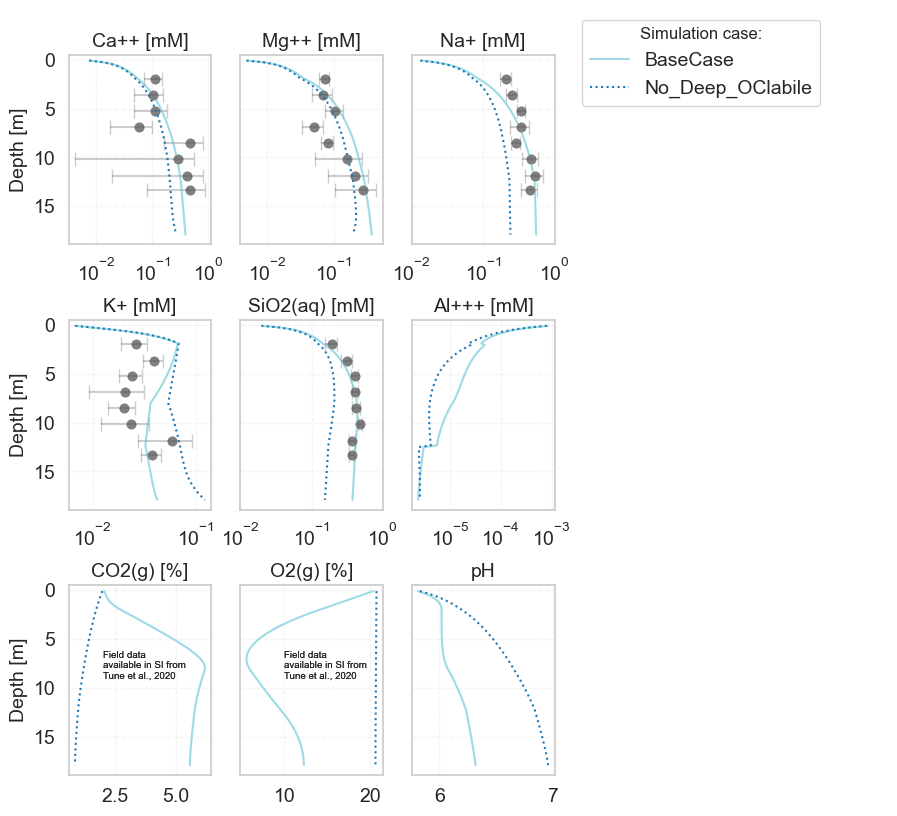

In [31]:
fig = Krunchmanday.plot_Figure3(dfs_output, simulation_cases, df_vms)
plt.show()

### Compute fluxes in Simulation

In [61]:
root = '../GitHub_Zenodo_repo/1D_model/Figure4_simulations/'
results = []
error_cases = []
fluxes_df = pd.DataFrame()
vars_to_assemble = ['totcon', 'conc']

for watsat in ['15', '23', '25', '30', '35', '40', '50']:
    for BC, BC_value in zip(['4E-2', '17E-3', '2E-2', '23E-3', '1E-2'],
                           [4E-2, 1.7E-2, 2E-2, 2.3E-2, 1.2E-2]):
        working_folder = os.path.join(root, f'CoxNoCox_Sat_1R{watsat}_CO2_{BC}')        
        case_name = os.listdir(working_folder)[-1] #take a random case_name from folder, just to input dfs_output_fun
        if os.path.isdir(os.path.join(working_folder, case_name)):
            dfs_output, BK_dict = Krunchmanday.dfs_output_fun(working_folder, vars_to_assemble, case_name)  
        
        np.sort(list(dfs_output.keys()))
        for Flow, Flow_value in zip(['5.0E-01', '6.0E-01', '7.0E-01', '8.0E-01', '1.0E+00', '1.1E+00', '1.2E+00', '1.3E+00', '1.5E+00', '1.7E+00', '2.0E+00', 
                                     '2.3E+00', '2.5E+00', '3.0E+00', '3.5E+00', '4.0E+00', '5.0E+00', '6.0E+00', '8.0E+00', '1.0E+01'], 
                                    [0.5, 0.6, 0.7, 0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 2.3, 2.5, 3, 3.5, 4, 5, 6, 8, 10]):

            cont =0
            total_flux = [0, 0]
            flux_Na = [0, 0]
            flux_Ca = [0, 0]
            flux_Mg = [0, 0]
            flux_K = [0, 0]
            flux_Si = [0, 0]
            flux_alkalinity = [0, 0]
            Darcy_Flow = Flow_value #m/y
                
            try: 
                for case_name, text in zip([f'WithDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}', 
                                        f'NoDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'], 
                                      ['WithDeepOClabile', 'NoDeepOClabile']):
                    df = dfs_output[case_name]['totcon']
                    df_alkalinity = dfs_output[case_name]['conc']
                    # print(f'Values with {text}:')
                    flux_Ca[cont]=((df['Ca++'].iloc[index_above_watertable]  - df['Ca++'].iloc[0])#mol/L
                     *40#g/mol -> atomic mass
                     *Darcy_Flow# m3/m2/yr
                     *1000) #L/m3
                    flux_Mg[cont] = (df['Mg++'].iloc[index_above_watertable] - df['Mg++'].iloc[0])*24.3*Darcy_Flow*1000
                    flux_Na[cont] = (df['Na+'].iloc[index_above_watertable]  - df['Na+'].iloc[0])*22.98*Darcy_Flow*1000
                    flux_K[cont] = (df['K+'].iloc[index_above_watertable]  - df['K+'].iloc[0])*39.09*Darcy_Flow*1000
                    flux_Si[cont] = (df['SiO2(aq)'].iloc[index_above_watertable]  - df['SiO2(aq)'].iloc[0])*(28)*Darcy_Flow*1000
                    flux_alkalinity[cont] = (((10**df_alkalinity['HCO3-'].iloc[index_above_watertable] ) - \
                                             (10**df_alkalinity['HCO3-'].iloc[0]))*(61.05)+\
                                            ((10**df_alkalinity['CO3--'].iloc[index_above_watertable] ) - \
                                             (10**df_alkalinity['CO3--'].iloc[0]))*(60.042)\
                                            )*Darcy_Flow*1000
                    total_flux[cont] = np.sum([flux_Ca[cont], flux_Mg[cont], flux_Na[cont], flux_K[cont], flux_Si[cont]])

                    cont += 1

                Ecosystem_pct = 100*(total_flux[0] - total_flux[1])/total_flux[0]

                results.append([int(watsat[-2:]), round(BC_value * 100, 3), Flow_value, total_flux[0], 
                                total_flux[1], Ecosystem_pct, flux_alkalinity[0], flux_alkalinity[1]])
            except KeyError:
                error_cases.append(case_name)
                pass
            
columns = ['WatSat', 'BC_PCO2', 'Flow', 'Flux_CoxON', 'Flux_CoxOFF', 'Ecosystem_pct', 
           'Flux_alkalinity_CoxON', 'Flux_alkalinity_CoxOFF']
fluxes_df = pd.DataFrame(results, columns=columns)
fluxes_df = fluxes_df.assign(Diff_CoxON_OFF = lambda x: x.Flux_CoxON - x.Flux_CoxOFF)

print('Fluxes from simulation scenarios successfully stored in dataframe --> fluxes_df')

running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs_output_fun...
running function dfs

Generate report of solute fluxes computed from model scenarios: 

In [57]:
watsat = '25'
BC = '2E-2'

BK_dict = []
dfs_output = []
working_folder = os.path.join(root, f'CoxNoCox_Sat_1R{watsat}_CO2_{BC}')        
simulation_cases = os.listdir(os.path.join(working_folder))

for case_name in simulation_cases:
    if os.path.isdir(os.path.join(working_folder, case_name)):
        BK_df, output_df = Krunchmanday.build_output_df(working_folder, case_name)
        BK_dict.append(BK_df)
        dfs_output.append(output_df)
BK_dict = dict(zip(simulation_cases, BK_dict))
dfs_output = dict(zip(simulation_cases, dfs_output))

#------------------------------------
# Base Case scenario
Flow = '1.7E+00'
#------------------------------------
case_name = f'WithDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'
df = dfs_output[case_name]['totcon']

total_conc = Krunchmanday.compute_total_conc(df, index_above_watertable)

print(f'**************\n"Base Case" scenario') 
print(f'Delta C = C_bottom_BVZ - C_top_BVZ = {total_conc:.1f} mg/L')
aux_flux = fluxes_df.loc[(fluxes_df.Flow == 1.7)&
              (fluxes_df.BC_PCO2 == 2)&
              (fluxes_df.WatSat == 25), 'Flux_CoxON'].values[0]

print(f'Flux = {aux_flux:.0f} t km-2 yr-1\n')
#------------------------------------
# No deep OC scenario
Flow = '1.7E+00'
#------------------------------------
case_name = f'NoDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'
df = dfs_output[case_name]['totcon']

total_conc = Krunchmanday.compute_total_conc(df, index_above_watertable)

print(f'**************\n"No Deep OC" scenario\nDelta C= {total_conc:.1f} mg/L')

aux_flux = fluxes_df.loc[(fluxes_df.Flow == 1.7)&
              (fluxes_df.BC_PCO2 == 2)&
              (fluxes_df.WatSat == 25), 'Flux_CoxOFF'].values[0]

print(f'Flux = {aux_flux:.0f} t km-2 yr-1\n')
#------------------------------------
# No deep OC scenario
Flow = '2.3E+00'
#------------------------------------
case_name = f'NoDeepOClabile-soilpCO2_{BC}_Flow{Flow}_Sat_1R{watsat}'
df = dfs_output[case_name]['totcon']

total_conc = Krunchmanday.compute_total_conc(df, index_above_watertable)

print(f'**************\n"No Plants" scenario\n Delta C= {total_conc:.1f} mg/L')

aux_flux = fluxes_df.loc[(fluxes_df.Flow == 2.3)&
              (fluxes_df.BC_PCO2 == 2)&
              (fluxes_df.WatSat == 25), 'Flux_CoxOFF'].values[0]

print(f'Flux = {aux_flux:.0f} t km-2 yr-1 \n')

**************
"Base Case" scenario
Delta C = C_bottom_BVZ - C_top_BVZ = 44.7 mg/L
Flux = 76 t km-2 yr-1

**************
"No Deep OC" scenario
Delta C= 25.2 mg/L
Flux = 43 t km-2 yr-1

**************
"No Plants" scenario
 Delta C= 22.3 mg/L
Flux = 51 t km-2 yr-1 



### Uncertainty propagation

In [63]:
#############
#Field fluxes estimated from VMS solute data (include stddev by concentration and drainage)
#############
print(f'Field fluxes from VMS data: {Flux_field:.0f} +/- {Std_Flux_field:.0f} ton/m2/yr\n')
#--------------------------------------------
#############
#Ecosystem contribution in [%]
#############
aux_avg = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 2), 
        ['Ecosystem_pct', 'Flux_CoxON', 'Flux_CoxOFF', 'Flux_alkalinity_CoxON', 'Flux_alkalinity_CoxOFF']].reset_index(drop = True)
aux_low = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 1.7),['Ecosystem_pct']].reset_index(drop = True)
aux_high = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 2.3),['Ecosystem_pct']].reset_index(drop = True)
Eel_eco_pct = [aux_low['Ecosystem_pct'].values[0], aux_avg['Ecosystem_pct'].values[0], aux_high['Ecosystem_pct'].values[0]] 
print('For pCO2 range [1.7%, 2%, 2.3%], Ecosys contribution [%] is:', [f"{x:.2f}" for x in Eel_eco_pct])

std_Eco_part = (Eel_eco_pct[0] - Eel_eco_pct[2])/2
print(f'Based on the above range, the stddev for the average ecosys contribution is: {std_Eco_part:.1f} %')
#--------------------------------------------
#############
#Ecosystem contribution as flux
#############
low = Flux_field*Eel_eco_pct[2]/100
avg = Flux_field*Eel_eco_pct[1]/100
up = Flux_field*Eel_eco_pct[0]/100
stddev = (up - low)/2
Eco_part = Flux_field*aux_avg['Ecosystem_pct'].values[0]/100
print(f'\nEcosystem contribution as flux: {Eco_part:.1f} +/- {stddev:.1f} t/m2/yr (computed on the field avg flux)')
#--------------------------------------------
#############
#Fold increase due to ecosystem
#############
aux_low = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 1.7),['Flux_CoxON', 'Flux_CoxOFF']].reset_index(drop = True)
aux_high = fluxes_df.loc[(fluxes_df.Flow == 1.7)&(fluxes_df.WatSat == 25)&(fluxes_df.BC_PCO2 == 2.3),['Flux_CoxON', 'Flux_CoxOFF']].reset_index(drop = True)

stddev_CoxON = abs(aux_high['Flux_CoxON'].values[0] - aux_low['Flux_CoxON'].values[0])/2
stddev_CoxOFF = abs(aux_high['Flux_CoxOFF'].values[0] - aux_low['Flux_CoxOFF'].values[0])/2

fold_increase = aux_avg['Flux_CoxON'].values[0]/aux_avg['Flux_CoxOFF'].values[0]
fold_std = fold_increase*np.sqrt(((stddev_CoxOFF/aux_avg['Flux_CoxOFF'].values[0])**2) + ((stddev_CoxON/aux_avg['Flux_CoxON'].values[0])**2))
print(f'\nBase flux (Flux_CoxOFF) increases by {fold_increase:.1f} +/- {fold_std:.1f} times')
#--------------------------------------------
#############
#Alkalinity increase
#############
aux_avg_up = fluxes_df.loc[(fluxes_df.Flow.isin([2, 1.7, 1.3]))&
       (fluxes_df.WatSat.isin([20, 25, 30]))&
        (fluxes_df.BC_PCO2.isin([1.7, 2, 2.5])), 
        ['Flow', 'WatSat', 'BC_PCO2', 'Flux_alkalinity_CoxON', 
         'Flux_alkalinity_CoxOFF']].reset_index(drop = True)
aux_avg_up = aux_avg_up.assign(alkalinity_gain_sum = lambda x: x.Flux_alkalinity_CoxON - x.Flux_alkalinity_CoxOFF)
aux_avg_up = aux_avg_up.assign(alkalinity_gain_ratio = lambda x: x.Flux_alkalinity_CoxON / x.Flux_alkalinity_CoxOFF)

std_alk_sum = (aux_avg_up.alkalinity_gain_sum.max()-aux_avg_up.alkalinity_gain_sum.min())/2
std_alk_ratio = (aux_avg_up.alkalinity_gain_ratio.max()-aux_avg_up.alkalinity_gain_ratio.min())/2

aux = aux_avg.iloc[0,3] - aux_avg.iloc[0,4]
print('\n#################\n', f'Alkalinity export : {aux:.1f} +/- {std_alk_sum:.1f}ton/m2/yr', 
     ' (error based in flow, WatSat & soil pCO2 variability)')
aux = aux_avg.iloc[0,3] / aux_avg.iloc[0,4]

print(f'Vegetation increases alkalinity by: {aux:.1f} +/- {std_alk_ratio:.1f} times\n#################')

Field fluxes from VMS data: 81 +/- 34 ton/m2/yr

For pCO2 range [1.7%, 2%, 2.3%], Ecosys contribution [%] is: ['46.46', '43.53', '41.02']
Based on the above range, the stddev for the average ecosys contribution is: 2.7 %

Ecosystem contribution as flux: 35.2 +/- 2.2 t/m2/yr (computed on the field avg flux)

Base flux (Flux_CoxOFF) increases by 1.8 +/- 0.1 times

#################
 Alkalinity export : 75.0 +/- 7.8ton/m2/yr  (error based in flow, WatSat & soil pCO2 variability)
Vegetation increases alkalinity by: 1.7 +/- 0.2 times
#################


## Figure 4 - Sensitivity analysis

### Compute Fig 4 transform

## Compute transform

/Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/Plotting/Krunchmanday.py:425: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grouped_watsat = df_watsat.groupby('Flow')['Ecosystem_pct'].mean().reindex(curves['Flow']).fillna(method='ffill').fillna(method='bfill')


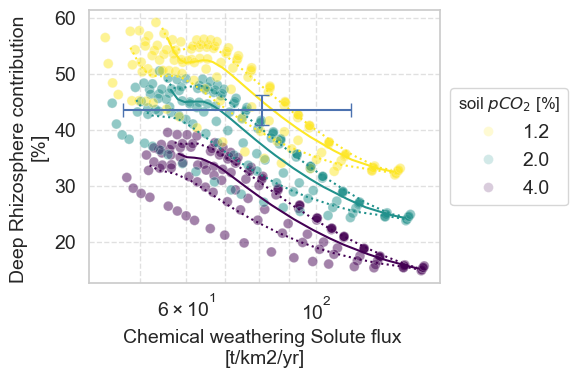

In [122]:
mean_ci_curves, best_watsat_for_MUL, transformed_MUL, aux, polynomial_coefficients = Krunchmanday.process_flux_data(fluxes_df)

# Initialize a figure with two subplots
fig, ax = plt.subplots(figsize=(6, 4))

colors = Krunchmanday.create_color_list(range(3), 'viridis')
labels = [False, False, 'auto']
cont = 0

# Loop over each 'BC_PCO2' level to plot the curves
for bc_pco2_level, curves in mean_ci_curves.items():
    
    # Get the best 'WatSat' values for this 'BC_PCO2' level
    best_watsat = best_watsat_for_MUL[bc_pco2_level]
    
    # Transform the Flow values to Flux_CoxON for each of Mean, CI_Lower, and CI_Upper
    transformed_flux_coxon_mean = np.array([Krunchmanday.transform_flow_to_flux(flow, best_watsat['Mean'], bc_pco2_level, polynomial_coefficients) for flow in curves['Flow']])
    transformed_flux_coxon_lower = np.array([Krunchmanday.transform_flow_to_flux(flow, best_watsat['CI_Lower'], bc_pco2_level, polynomial_coefficients) for flow in curves['Flow']])
    transformed_flux_coxon_upper = np.array([Krunchmanday.transform_flow_to_flux(flow, best_watsat['CI_Upper'], bc_pco2_level, polynomial_coefficients) for flow in curves['Flow']])
    
    # Plot M-U-L curves in the 'Flux_CoxON' space (x-axis transformed separately)
    ax.plot(transformed_flux_coxon_mean, curves['Mean'], color=colors[cont], linestyle = '-')
    ax.plot(transformed_flux_coxon_lower, curves['CI_Lower'], color=colors[cont] , linestyle = ':')
    ax.plot(transformed_flux_coxon_upper, curves['CI_Upper'], color=colors[cont], linestyle = ':')
    sns.scatterplot(data=aux, x='Flux_CoxON', y='Ecosystem_pct', hue='BC_PCO2', 
                    ax = ax, palette=colors[::-1], s=50, legend = labels[cont], alpha = 0.2)
    
    cont +=1 

ax.errorbar(x = Flux_field, xerr = Std_Flux_field, y = Eel_eco_pct[1], yerr = std_Eco_part, capsize = 5, )
    
# Customize the right subplot (Flux_CoxON space)
ax.set_xlabel('Chemical weathering Solute flux \n[t/km2/yr]')
ax.set_ylabel('Deep Rhizosphere contribution \n[%]')  # Y-axis remains 'Ecosystem_pct'
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), title = 'soil $pCO_2$ [%]')
ax.grid(True, which = 'both', linestyle = '--', alpha = 0.6)
ax.set_xscale('log')

fig.tight_layout()
plt.show()

CoxNoCox_Sat_1R15_CO2_1E-2

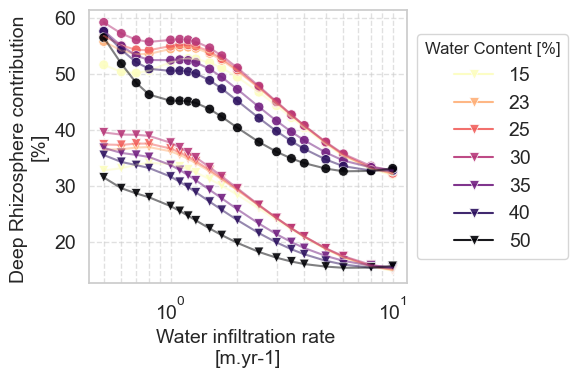

In [128]:
# Initialize a figure with two subplots
fig, ax = plt.subplots(figsize=(6, 4))

colors = Krunchmanday.create_color_list(aux.WatSat.unique(), 'magma')
labels = [False, 'auto']
cont = 0

# Loop over each 'BC_PCO2' level to plot the curves
for bc_pco2_level, marker, legendflag in zip([1.2, 4], ['o', 'v'], [False, True]):
    
    aux_plot = aux.loc[(aux.BC_PCO2 == bc_pco2_level)]
    sns.lineplot(data=aux_plot, x='Flow', y='Ecosystem_pct', hue='WatSat', style = 'BC_PCO2', 
                    ax = ax, palette=colors[::-1], alpha = 0.5, legend = False)
    sns.scatterplot(data=aux_plot, x='Flow', y='Ecosystem_pct', hue='WatSat', marker = marker, linestyle = '-', 
                    ax = ax, palette=colors[::-1], s=50, legend = legendflag, alpha = 0.9)
    cont +=1 
# Customize the right subplot (Flux_CoxON space)
ax.set_xlabel('Water infiltration rate \n[m.yr-1]')
ax.set_ylabel('Deep Rhizosphere contribution \n[%]')  # Y-axis remains 'Ecosystem_pct'
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), title = 'Water Content [%]')
ax.grid(True, which = 'both', linestyle = '--', alpha = 0.6)
ax.set_xscale('log')

# Show the plots
fig.tight_layout()
plt.show()

-------------------------

# Uncertainty propagation

## Fluxes

In [273]:
results_df = pd.read_table(os.path.join(root, 'Fittings/1D_ResearchScenarios', 'fluxes_df_HighFlowRes_V2.csv'), sep = ',')
#############
#Field fluxes estimated from VMS solute data (include stddev by concentration and drainage)
#############
print(f'Field fluxes from VMS data: {total_flux} +/- {Std_Flux_field}ton/m2/yr\n')
#--------------------------------------------
#############
#Ecosystem contribution in [%]
#############
aux_avg = results_df.loc[(results_df.Flow == 1.7)&
       (results_df.WatSat == 25)&
        (results_df.BC_PCO2 == 2), 
        ['Ecosystem_pct', 'Flux_CoxON', 'Flux_CoxOFF', 'Flux_alkalinity_CoxON', 'Flux_alkalinity_CoxOFF']].reset_index(drop = True)
#Ecosystem contrib Computed from model within variability range for BC_pCO2 [1.7%, 2%, 2.3%]
Eel_eco_pct = [46.310999, aux_avg['Ecosystem_pct'].values[0], 40.914601] 
print('For pCO2 range [1.7%, 2%, 2.3%], Ecosys contribution [%] is:', Eel_eco_pct)

aux = Eel_eco_pct[0] - Eel_eco_pct[1]
print(f'Based on the above range, the stddev for the average ecosys contribution is: {aux:.1f} %')
#--------------------------------------------
#############
#Ecosystem contribution as flux
#############
low = Eel_flux*Eel_eco_pct[2]/100
avg = Eel_flux*Eel_eco_pct[1]/100
up = Eel_flux*Eel_eco_pct[0]/100
stddev = (up - low)/2
# Eco_part = aux_avg['Flux_CoxON'].values[0] - aux_avg['Flux_CoxOFF'].values[0]
Eco_part = Eel_flux*aux_avg['Ecosystem_pct'].values[0]/100
print(f'\nEcosystem contribution as flux: {Eco_part:.1f} +/- {stddev:.1f} t/m2/yr (computed on the field avg flux)')
#--------------------------------------------
#############
#Fold increase due to ecosystem
#############
fold_increase = aux_avg['Flux_CoxON'].values[0]/aux_avg['Flux_CoxOFF'].values[0]
fold_std = fold_increase*np.sqrt(((2/43.7)**2)+((23/77.3)**2))
print(f'\nBase flux (Flux_CoxOFF) increases by {fold_increase:.1f} +/- {fold_std:.1f} times')
#--------------------------------------------
#############
#Base case flux reduces of XX if roots are not working
#############
aux = aux_avg['Flux_CoxON'].values[0]/aux_avg['Flux_CoxOFF'].values[0]
#--------------------------------------------
#############
#Alkalinity increase
#############
aux_avg_up = results_df.loc[(results_df.Flow.isin([2, 1.7, 1.3]))&
       (results_df.WatSat.isin([20, 25, 30]))&
        (results_df.BC_PCO2.isin([1.7, 2, 2.5])), 
        ['Flow', 'WatSat', 'BC_PCO2', 'Flux_alkalinity_CoxON', 
         'Flux_alkalinity_CoxOFF']].reset_index(drop = True)
aux_avg_up = aux_avg_up.assign(alkalinity_gain_sum = lambda x: x.Flux_alkalinity_CoxON - x.Flux_alkalinity_CoxOFF)
aux_avg_up = aux_avg_up.assign(alkalinity_gain_ratio = lambda x: x.Flux_alkalinity_CoxON / x.Flux_alkalinity_CoxOFF)

std_alk_sum = (aux_avg_up.alkalinity_gain_sum.max()-aux_avg_up.alkalinity_gain_sum.min())/2
std_alk_ratio = (aux_avg_up.alkalinity_gain_ratio.max()-aux_avg_up.alkalinity_gain_ratio.min())/2

aux = aux_avg.iloc[0,3] - aux_avg.iloc[0,4]
print('\n#################\n', f'Alkalinity export : {aux:.1f} +/- {std_alk_sum:.1f}ton/m2/yr', 
     ' (error based in flow, WatSat & soil pCO2 variability)')
aux = aux_avg.iloc[0,3] / aux_avg.iloc[0,4]

print(f'Vegetation increases alkalinity by: {aux:.1f} +/- {std_alk_ratio:.1f} times\n#################')

Field fluxes from VMS data: 80.4 +/- 34ton/m2/yr

For pCO2 range [1.7%, 2%, 2.3%], Ecosys contribution [%] is: [46.310999, 43.410985117895976, 40.914601]
Based on the above range, the stddev for the average ecosys contribution is: 2.9 %

Ecosystem contribution as flux: 34.9 +/- 2.2 t/m2/yr (computed on the field avg flux)

Base flux (Flux_CoxOFF) increases by 1.8 +/- 0.5 times

#################
 Alkalinity export : 77.9 +/- 8.7ton/m2/yr  (error based in flow, WatSat & soil pCO2 variability)
Vegetation increases alkalinity by: 1.7 +/- 0.2 times
#################


----------

# Repository for GitHub: CrunchFlow I/O files

Brind simulation cases from master folder to repo folder

In [627]:
fitting_case = 'U_BaseCase'
source_path = os.path.join(root, results_folder, fitting_case)
caseslist = os.listdir(source_path)

try:
    caseslist.remove('.DS_Store')
except:
    next
caseslist = np.sort(caseslist)

destination_path = '/Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/'
try:
    os.mkdir(os.path.join(destination_path, fitting_case))
except:
    next
    
for file in caseslist:
    source_file = os.path.join(source_path, file)
    destination_file = os.path.join(destination_path, fitting_case, file)
    shutil.copytree(source_file, destination_file)

Keep only essential output in every simulation case's folder

In [689]:
fitting_case = 'Figure3_simulations'
caseslist = os.listdir(os.path.join(destination_path, fitting_case))

try:
    caseslist.remove('.DS_Store')
except:
    next
caseslist = np.sort(caseslist)

# Define the path to the folder and the list of allowed filenames
for file in caseslist:
    aux_path = os.path.join(destination_path, fitting_case, file)
    file_list = os.listdir(aux_path)

    # Specify the list of filenames you want to keep
    allowed_filenames = [
        'DBS_NoEa.txt',
        'gases1.txt',
        'exchange1.txt',
        'totcon1.txt',
        'saturation1.txt',
        'conc1.txt'
    ]

    # Initialize variable to store the "Bkp..." file name
    bkp_file = None

    # Look for the file starting with "Bkp"
    for filename in file_list:
        if filename.startswith("Bkp") and filename.endswith(".txt"):
            bkp_file = filename
            break  # Exit the loop once the "Bkp" file is found

    # Rename the "Bkp..." file to "input_file.txt" if it exists
    if bkp_file:
        bkp_file_path = os.path.join(aux_path, bkp_file)
        new_bkp_file_path = os.path.join(aux_path, "input_file.txt")
        os.rename(bkp_file_path, new_bkp_file_path)
        print(f"Renamed '{bkp_file}' to 'input_file.txt'")
        allowed_filenames.append("input_file.txt")  # Add the new name to the allowed filenames

    # Iterate over files in the folder and delete those not in the allowed list
    for filename in file_list:
        file_path = os.path.join(aux_path, filename)
        if filename not in allowed_filenames:
            if os.path.isfile(file_path):  # Ensure it's a file, not a subdirectory
                os.remove(file_path)  # Delete the file
                print(f"Deleted: {file_path}")
            else:
                print(f"Skipped (not a file): {file_path}")

Renamed 'Bkp_DBS_NoEa.dbs-POMCm11_IlliKin-47NoDol_FixO2s-.txt' to 'input_file.txt'
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/NoDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R10/MineralPercent1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/NoDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R10/rate1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/NoDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R10/BK_Md_dum-AqKin1.0E-05-dum-Flow1.0E+00-LastBatch_CO2_1E-2-Sat_1R10.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/NoDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R10/area1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/NoDeepOClabile-soilpCO2_1E-2_Fl

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/WithDeepOClabile-soilpCO2_4E-2_Flow3.5E+00_Sat_1R35/MineralPercent1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/WithDeepOClabile-soilpCO2_4E-2_Flow3.5E+00_Sat_1R35/rate1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/WithDeepOClabile-soilpCO2_4E-2_Flow3.5E+00_Sat_1R35/area1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/WithDeepOClabile-soilpCO2_4E-2_Flow3.5E+00_Sat_1R35/run_log.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/WithDeepOClabile-soilpCO2_4E-2_Flow3.5E+00_Sat_1R35/porosity1.txt
Deleted: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figu

Copy into every simulation case the files needed to run crunch

In [696]:
child_folder

'NoDeepOClabile-soilpCO2_1E-2_Flow1.2E+00_Sat_1R23'

In [698]:
# Define the parent directory
fitting_case = 'Figure3_simulations'
parent_directory = os.path.join(destination_path, fitting_case)

# Define the static files to be copied to all child folders
static_files = ["Aqueous.dbs", "AqueousControl.ant", "PestControl.ant"]

# List all available Sat_1RXX.txt files in the parent directory
sat_files = {f for f in os.listdir(parent_directory) if re.match(r"Sat_1R\d{2}\.txt", f)}

# Iterate through child folders
for child_folder in os.listdir(parent_directory):
    child_path = os.path.join(parent_directory, child_folder)

    # Ensure it's a directory
    if os.path.isdir(child_path):
        # Copy static files to the child folder
        for file in static_files:
            source_file = os.path.join(parent_directory, file)
            destination_file = os.path.join(child_path, file)
            if os.path.exists(source_file):
                shutil.copy(source_file, destination_file)
                print(f"Copied {file} to {child_folder}")

        # Extract the Sat_1RXX pattern from the folder name
        match = re.search(r"Sat_1R\d{2}", child_folder)
        if match:
            sat_pattern = match.group() + ".txt"  # e.g., "Sat_1R15.txt"

            # Check if the corresponding Sat_1RXX.txt file exists in the parent directory
            if sat_pattern in sat_files:
                sat_source = os.path.join(parent_directory, sat_pattern)
                sat_destination = os.path.join(child_path, sat_pattern)
                shutil.copy(sat_source, sat_destination)
                print(f"Copied {sat_pattern} to {child_folder}")


Copied Aqueous.dbs to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R20
Copied AqueousControl.ant to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R20
Copied PestControl.ant to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R20
Copied Sat_1R20.txt to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+00_Sat_1R20
Copied Aqueous.dbs to WithDeepOClabile-soilpCO2_4E-2_Flow1.0E+01_Sat_1R40
Copied AqueousControl.ant to WithDeepOClabile-soilpCO2_4E-2_Flow1.0E+01_Sat_1R40
Copied PestControl.ant to WithDeepOClabile-soilpCO2_4E-2_Flow1.0E+01_Sat_1R40
Copied Sat_1R40.txt to WithDeepOClabile-soilpCO2_4E-2_Flow1.0E+01_Sat_1R40
Copied Aqueous.dbs to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+01_Sat_1R20
Copied AqueousControl.ant to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+01_Sat_1R20
Copied PestControl.ant to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+01_Sat_1R20
Copied Sat_1R20.txt to WithDeepOClabile-soilpCO2_1E-2_Flow1.0E+01_Sat_1R20
Copied Aqueous.dbs to WithDeepOClabile-soilpCO2_2E-2_Flow8.0E-01_Sat_1R25
Co

Simplify dirnames for simulation cases

In [679]:
# Define the path where directories are located
fitting_case = 'Figure3_simulations'
directory_path = os.path.join(destination_path, fitting_case)

# Iterate through directories inside the main directory
for i in os.listdir(directory_path): 
    if i == '.DS_Store':
            next
    else:
        sub_dir_path = os.path.join(directory_path, i)  # Full path of the subdirectory
        for j in os.listdir(sub_dir_path):
            if j == '.DS_Store':
                next
            else:
                case_path = os.path.join(sub_dir_path, j)  # Full path of the simulation case
                # Ensure it's a directory before processing
                if os.path.isdir(case_path):
                    new_name = j  # Start with the original name

                    # Apply replacements
                    new_name = new_name.replace("AqKin1.0E+07-CO2", "WithDeepOClabile-soilpCO2")
                    new_name = new_name.replace("AqKin1.0E-05-NoCoxCO2", "NoDeepOClabile-soilpCO2")
                    new_name = new_name.replace("dum-", "")

                    # Rename only if there's a change
                    if new_name != j:
                        new_case_path = os.path.join(sub_dir_path, new_name)
                        os.rename(case_path, new_case_path)
                        # print(f"Renamed: {i} -> {new_name}")

# List the updated directory names for verification
print("Updated directory names:")
for dirname in os.listdir(sub_dir_path):
    print(dirname)

Updated directory names:
WithDeepOClabile-soilpCO2_4E-2_Flow7.0E-01_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow4.0E+00_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow3.0E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow1.5E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow1.2E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow8.0E-01_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow2.0E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow6.0E-01_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow5.0E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow1.3E+00_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow1.1E+00_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow8.0E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow2.5E+00_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow1.7E+00_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow1.0E+01_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow1.0E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow3.5E+00_Sat_1R50
NoDeepOClabile-soilpCO2_4E-2_Flow6.0E+00_Sat_1R50
WithDeepOClabile-soilpCO2_4E-2_Flow5.0E-01_Sat_1R50
NoDeepO

Eliminate intermediate directories in the tree

In [681]:
# Define the parent directory
fitting_case = 'Figure3_simulations'
parent_directory = os.path.join(destination_path, fitting_case)

# Iterate through the first level directories
for intermediate_dir in os.listdir(parent_directory):
    intermediate_path = os.path.join(parent_directory, intermediate_dir)

    # Ensure it's a directory before proceeding
    if os.path.isdir(intermediate_path):
        # Iterate through the subdirectories (target directories)
        for target_dir in os.listdir(intermediate_path):
            target_path = os.path.join(intermediate_path, target_dir)
            new_target_path = os.path.join(parent_directory, target_dir)

            # Ensure it's a directory and avoid overwriting existing folders
            if os.path.isdir(target_path):
                # Move target directory to the parent directory
                shutil.move(target_path, new_target_path)
                print(f"Moved: {target_path} -> {new_target_path}")

        # Remove the now-empty intermediate directory
        try:
            os.rmdir(intermediate_path)
            # print(f"Deleted empty folder: {intermediate_path}")
        except OSError:
            print(f"Could not delete {intermediate_path}, it may not be empty.")

Moved: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/CoxNoCox_Sat_1R23_CO2_1E-2/NoDeepOClabile-soilpCO2_1E-2_Flow6.0E+00_Sat_1R23 -> /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/NoDeepOClabile-soilpCO2_1E-2_Flow6.0E+00_Sat_1R23
Moved: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/CoxNoCox_Sat_1R23_CO2_1E-2/WithDeepOClabile-soilpCO2_1E-2_Flow5.0E-01_Sat_1R23 -> /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/WithDeepOClabile-soilpCO2_1E-2_Flow5.0E-01_Sat_1R23
Moved: /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulations/CoxNoCox_Sat_1R23_CO2_1E-2/WithDeepOClabile-soilpCO2_1E-2_Flow3.5E+00_Sat_1R23 -> /Users/ivano/Documents/PostDoc-UIUC/Paper1/Submission_AGU_Advances/GitHub_Zenodo_repo/Figure3_simulatio

# Repository for HydroShare: VMS solute data

The purpose is to verify what information has already been made available in the datasets from Golla EPSL papers, and Tune 2020

In [578]:
chem_no_outliers_pivoted = pd.read_csv('/Users/ivano/Documents/PostDoc-UIUC/Paper1/CrunchModels/1D_VMS/chem_no_outliers.csv')
chem_no_outliers_pivoted.Date = pd.to_datetime(chem_no_outliers_pivoted.Date)
df_repo = pd.melt(chem_no_outliers_pivoted, 
                id_vars = ['ID', 'Depth_m', 'Date'], 
                value_vars = ['Ca_mM', 'K_mM', 'Mg_mM','Na_mM', 'Si_mM'], 
                var_name = 'Variable', value_name = 'Value')

# Preserve only the data that is not already present in the repos from Golla 2021 EPSL and Tune 2020 JGR Bio
df_repo = df_repo.loc[~((df_repo.Date.isin(['2017-09-10', '2017-12-04'])&(df_repo.ID == 'A8')&(df_repo.Variable.isin(['Ca_mM', 'K_mM', 'Mg_mM', 'Na_mM'])))|
                            ((df_repo.Date == '2017-04-22')&(df_repo.ID == 'A7')&(df_repo.Variable.isin(['Ca_mM', 'K_mM', 'Mg_mM', 'Na_mM'])))|
                            ((df_repo.Date == '2019-03-02')&(df_repo.Variable == 'Na_mM')))]
df_repo = df_repo.dropna(subset = 'Value')
df_repo.columns = ['VMS_port_ID', 'Avg_Depth_m', 'Date', 'Variable', 'Value']
df_repo['Material sampled'] = 'Weathered bedrock'

def determine_saturation(vms_id):
    if vms_id in ['A1', 'A2', 'A3', 'A4']:
        return 'unsaturated'
    elif vms_id in ['A5', 'A6', 'A7', 'A8']:
        return 'seasonally saturated'
    else:
        return 'saturated year-round'

df_repo['Saturation_state'] = df_repo['VMS_port_ID'].apply(determine_saturation)

df_repo.to_csv('../../Submission_AGU_Advances/HydroShare_repo/VMSsolutes_Osorio-Leon_etal_2025_AGUAdvances.csv', index = False)

What is available in previous repos:

In [552]:
print('****** All gas data is already published in Tune et al. 2020 ******\n||\n****** Solutes ******')
print('Golla et al., 2021. EPSL: Na \t |All ports| \t |03/03/2019|')
print('\nTune et al., 2020. JGR Bio: \nCO2(g), O2(g) \t\t\t |All ports| \t |04/22/2017, 09/10/2017, 04/28/2018, 13/10/2018, 14/04/2019|')
print('Major solutes (except SiO2) \t |12.2 m| \t |04/22/2017, 09/10/2017, 05/12/2017|')

****** All gas data is already published in Tune et al. 2020 ******
||
****** Solutes ******
Golla et al., 2021. EPSL: Na 	 |All ports| 	 |03/03/2019|

Tune et al., 2020. JGR Bio: 
CO2(g), O2(g) 			 |All ports| 	 |04/22/2017, 09/10/2017, 04/28/2018, 13/10/2018, 14/04/2019|
Major solutes (except SiO2) 	 |12.2 m| 	 |04/22/2017, 09/10/2017, 05/12/2017|


# Postpro

## Build export plots

### Plot all iterations in a same plot

In [389]:
chem_no_outliers_pivoted = pd.read_csv('/Users/ivano/Documents/PostDoc-UIUC/Paper1/CrunchModels/1D_VMS/chem_no_outliers.csv')

sns.set_theme(style='whitegrid')

str_in_case = 'V_NoPlants_Fluxes'
results_folder = 'Fittings/1D_ResearchScenarios'
Figures_folder = 'Fittings'
# results_folder = 'Fittings/1D_ResearchScenarios/S_TemperatureEffect_Tok_CopyForPlot'
# Figures_folder = 'Fittings/S_TemperatureEffect'

gas_out = 'gases' #gas or gases
vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate', 'AqRate', 'totexchange', 'exchange', gas_out]
VMS_choice = ['A']
output_times =  time_sim
    
def make_ivo_plots(myfun, export_label, fitting_case, dfs_output):
    fig, fitting_case, _iterated_param, _rock_domain, _initial_condition = myfun(vars_to_assemble, VMS_choice, output_times, gas_out, 
                                                                                 fitting_case, dfs_output)

    try: 
        os.mkdir(os.path.join(MyFigures_root, Figures_folder, fitting_case))
    except: 
        pass

    print('exporting ', os.path.join(MyFigures_root, Figures_folder, fitting_case, f'{export_label}.svg'))
    fig.savefig(os.path.join(MyFigures_root, Figures_folder, fitting_case, f'{export_label}.png'))
    plt.close()
    
    return _iterated_param, _rock_domain, fitting_case, _initial_condition
    
    
for fitting_case in os.listdir(os.path.join(root, results_folder)):
    if str_in_case in fitting_case: 
        working_folder = os.path.join(root, results_folder, fitting_case)
        
        # for fun, export_label in zip([plot_sensitivity_results_Majors_mod, plot_sensitivity_results_Cox_mod, 
        #                              plot_sensitivity_results_Minerals_mod, plot_sensitivity_results_MinSaturation_mod, 
        #                              plot_sensitivity_results_Redox_mod, plot_sensitivity_results_Exchangers_mod],
        #                             ['Solutes', 'CarbonOxid', 'MineralRates', 'MinSaturation', 'Redox', 'Exchangers']):
        for fun, export_label in zip([plot_sensitivity_results_Cox_mod, plot_sensitivity_results_Majors_mod, plot_sensitivity_results_Minerals_mod,
                                     plot_sensitivity_results_MinSaturation_mod],
                                    ['CarbonOxid', 'Solutes', 'MineralRates', 'MinSaturation']):
            cases = [x for x in os.listdir(working_folder) if x != '.DS_Store']
            case_name = random.choice(cases)
            dfs_output, BK_dict = dfs_output_fun(working_folder, vars_to_assemble, case_name)
            _iterated_param, _rock_domain, fitting_case, _initial_condition = make_ivo_plots(fun, export_label, fitting_case, dfs_output)
            print('iterated_param = ',_iterated_param,'\nrock_domain = ', _rock_domain,'\nfitting_case = ', fitting_case, 
                 '\ninitial condition = ', _initial_condition)

running function dfs_output_fun...
working on fitting_case =  V_NoPlants_Fluxes E+00-LastBatch_CO2_2E-2-Sat_1R25.txt

Plotting Domain: Unable_To_Find_The_Name  -  Initial cond: Unable_To_Find_The_Name
Plotting Domain: Unable_To_Find_The_Name  -  Initial cond: Unable_To_Find_The_Name
exporting  /Users/ivano/Documents/PostDoc-UIUC/Paper1/MyFigures/Crunch_Simulations/1D_VMS/Fittings/V_NoPlants_Fluxes/CarbonOxid.svg
iterated_param =  NoPlants 
rock_domain =  Unable_To_Find_The_Name 
fitting_case =  V_NoPlants_Fluxes 
initial condition =  Unable_To_Find_The_Name
running function dfs_output_fun...
working on fitting_case =  V_NoPlants_Fluxes E+00-LastBatch_CO2_2E-2-Sat_1R25.txt

Plotting Domain: Unable_To_Find_The_Name  -  Initial cond: Unable_To_Find_The_Name
Plotting Domain: Unable_To_Find_The_Name  -  Initial cond: Unable_To_Find_The_Name
exporting  /Users/ivano/Documents/PostDoc-UIUC/Paper1/MyFigures/Crunch_Simulations/1D_VMS/Fittings/V_NoPlants_Fluxes/Solutes.svg
iterated_param =  NoPla

Plot single simulation by plot

working on fitting_case =  CoxNoCox_Sat_1R70_CO2_4E-3 

Plotting Domain: 47HighDol_FixO2s  -  Initial cond: 
Plotting Domain: 47HighDol_FixO2s  -  Initial cond: 
Plotting Domain: 47HighDol_FixO2s  -  Initial cond: 
running function dfs_output_fun...
running function dfs_output_fun...dum-Flow1.7E+00-LastBatch_CO2_4E-3.txt


/var/folders/vd/7dktxzpx1znf5cxy_vwph1c00000gr/T/ipykernel_40632/1662923366.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu', len(aux_gas.year.unique()))  # Get 6 colors from the viridis palette


running function dfs_output_fun...dum-Flow1.0E+00-LastBatch_CO2_4E-3.txt


/var/folders/vd/7dktxzpx1znf5cxy_vwph1c00000gr/T/ipykernel_40632/1662923366.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu', len(aux_gas.year.unique()))  # Get 6 colors from the viridis palette


/var/folders/vd/7dktxzpx1znf5cxy_vwph1c00000gr/T/ipykernel_40632/1662923366.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu', len(aux_gas.year.unique()))  # Get 6 colors from the viridis palette


working on fitting_case =  CoxNoCox_Sat_1R70_CO2_4E-2 

Plotting Domain: 47HighDol_FixO2s  -  Initial cond: 
Plotting Domain: 47HighDol_FixO2s  -  Initial cond: 
Plotting Domain: 47HighDol_FixO2s  -  Initial cond: 
running function dfs_output_fun...
running function dfs_output_fun...dum-Flow2.0E+00-LastBatch_CO2_4E-2.txt


/var/folders/vd/7dktxzpx1znf5cxy_vwph1c00000gr/T/ipykernel_40632/1662923366.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu', len(aux_gas.year.unique()))  # Get 6 colors from the viridis palette


running function dfs_output_fun...dum-Flow1.0E+00-LastBatch_CO2_4E-2.txt


/var/folders/vd/7dktxzpx1znf5cxy_vwph1c00000gr/T/ipykernel_40632/1662923366.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu', len(aux_gas.year.unique()))  # Get 6 colors from the viridis palette


/var/folders/vd/7dktxzpx1znf5cxy_vwph1c00000gr/T/ipykernel_40632/1662923366.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu', len(aux_gas.year.unique()))  # Get 6 colors from the viridis palette


exporting  /Users/ivano/Library/CloudStorage/Box-Box/PostDoc-UIUC/Paper1/MyFigures/Crunch_Simulations/1D_VMS/Fittings/CoxNoCox_Sat_1R70_CO2_4E-2/Iter_Depth_profs__Sat.png
iterated_param =  Sat 
rock_domain =  47HighDol_FixO2s 
fitting_case =  CoxNoCox_Sat_1R70_CO2_4E-2 
initial condition =  


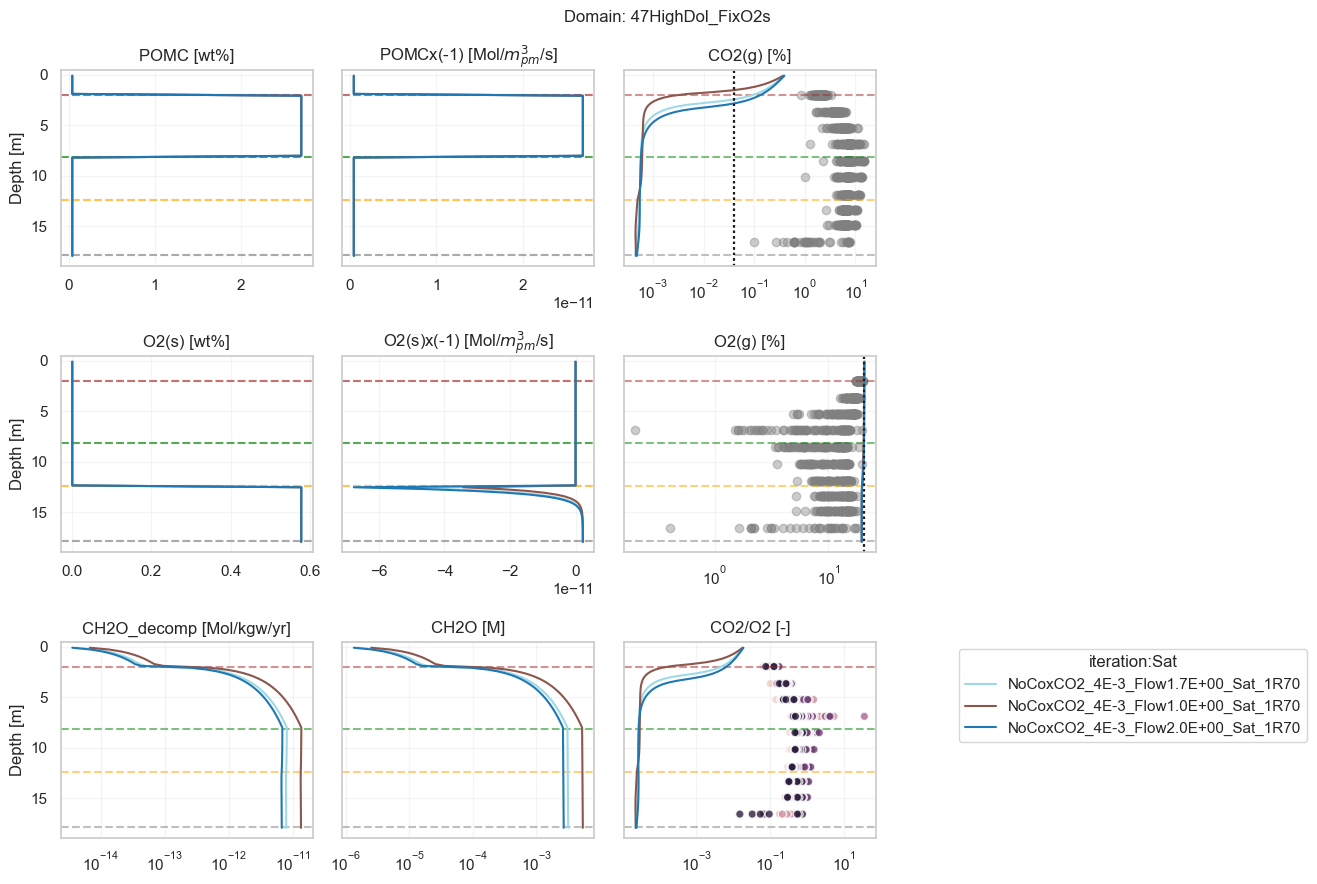

In [711]:
sns.set_theme(style='whitegrid')

str_in_case = 'CoxNoCox_Sat_'
results_folder = 'Fittings/1D_ResearchScenarios/P_SensitTestPlots'

gas_out = 'gases' #gas or gases
vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate', 'AqRate', 'totexchange', 'exchange', gas_out]
VMS_choice = ['A', 'B']
output_times =  time_sim
    
def make_ivo_plots(myfun, export_label):
    fig, fitting_case, _iterated_param, _rock_domain, _initial_condition = myfun(vars_to_assemble, VMS_choice, output_times, gas_out)

    try: 
        os.mkdir(os.path.join(MyFigures_root, 'Fittings', fitting_case))
    except: 
        pass

    print('exporting ', os.path.join(MyFigures_root, 'Fittings', fitting_case, f'Iter_Depth_profs_{_initial_condition}_{_iterated_param}.png'))
    fig.savefig(os.path.join(MyFigures_root, 'Fittings', fitting_case, f'Iter_{export_label}_profs_{_initial_condition}_{_iterated_param}.png'))
    plt.close()
    
    return _iterated_param, _rock_domain, fitting_case, _initial_condition
    
for fun, export_label in zip([plot_sensitivity_results_Cox_mod],
                            ['CarbonOxid']):
# for fun, export_label in zip([plot_sensitivity_results_Cox, plot_sensitivity_results_Redox, plot_sensitivity_results_Minerals, 
#                               plot_sensitivity_results_Majors, plot_sensitivity_results_MinSaturation, plot_sensitivity_results_CationRatios, 
#                              plot_sensitivity_results_Exchangers],
#                             ['CarbonOxid', 'Redox', 'MineralRate', 'Solutes', 'Saturation', 'Ratios', 'Exchangers']):
    
    _iterated_param, _rock_domain, fitting_case, _initial_condition = make_ivo_plots(fun, export_label)
    print('iterated_param = ',_iterated_param,'\nrock_domain = ', _rock_domain,'\nfitting_case = ', fitting_case, 
         '\ninitial condition = ', _initial_condition)

# # Plot correlation matrix
# correlation_matrix = compute_correlation_matrix(dfs_output, _iterated_param, target_time=50)

# fig, ax = plot_correlation_heatmap(correlation_matrix)

# print('exporting ', os.path.join(MyFigures_root, 'Fittings', fitting_case, f'CorrMatrix_{initial_condition}_{_rock_domain}.png'))
# fig.savefig(os.path.join(MyFigures_root, 'Fittings', fitting_case, f'CorrMatrix_{initial_condition}_{_rock_domain}.png'))
# plt.close()

### Plots CEC Supplements

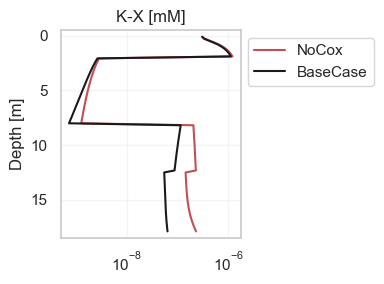

In [562]:
fig, ax = plt.subplots(figsize = (4,3))
for case, label, color in zip(['dum-AqKin1.0E-05-BaseCase', 'dum-AqKin1.0E+07-BaseCase'], ['NoCox', 'BaseCase'], ['r', 'k']):
    df_aux = dfs_output[case]['exchange']
    plt.plot(df_aux['KXEel'], df_aux['Distance'], label = label, color = color)
ax.legend(bbox_to_anchor = (1,1))
ax.set(ylim = (18.5, -0.5), ylabel = 'Depth [m]', title = 'K-X [mM]', xscale = 'log')
fig.tight_layout()
plt.savefig('/Users/ivano/Documents/PostDoc-UIUC/Paper1/Manuscript/Figures/SI/Zoom_CEC_figure.svg')

In [216]:
dfs_output.keys()

dict_keys(['dum-AqKin1.0E+07-KimCEC', 'dum-AqKin1.0E+07-NoCEC', 'dum-AqKin1.0E-05-KimCEC', 'dum-AqKin1.0E+07-BaseCase', 'dum-AqKin1.0E-05-NoCEC', 'dum-AqKin1.0E-05-BaseCase'])

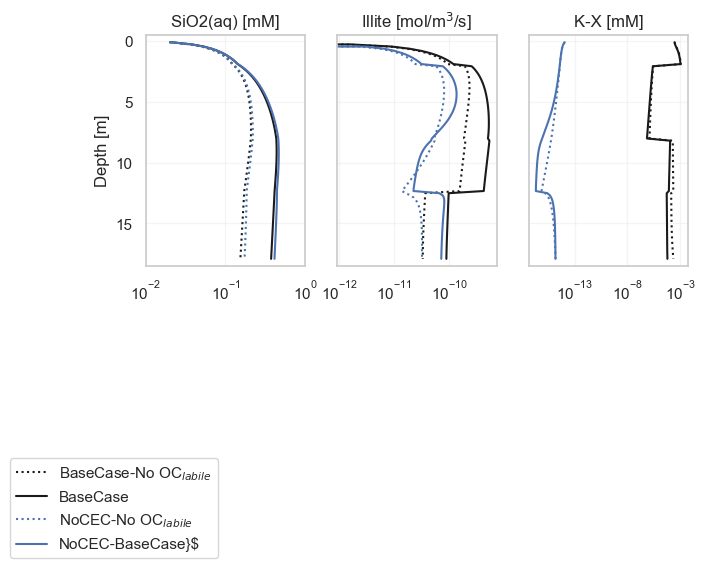

In [236]:
fig, axs = plt.subplots(1,3, figsize = (7,3), sharey = True)
ax = axs[0]
for case, label, color, linestyle in zip(['dum-AqKin1.0E-05-BaseCase', 'dum-AqKin1.0E+07-BaseCase', 'dum-AqKin1.0E-05-NoCEC', 'dum-AqKin1.0E+07-NoCEC'], 
                              ['BaseCase-No OC$_{labile}$', 'BaseCase', 'NoCEC-No OC$_{labile}$', 'NoCEC-BaseCase}$'], 
                              ['k', 'k', 'b', 'b'],
                              [':', '-', ':', '-']):
    df_aux = dfs_output[case]['totcon']
    ax.plot(df_aux['SiO2(aq)']*1000, df_aux['Distance'], label = label, color = color, linestyle = linestyle)
ax.legend(bbox_to_anchor = (0.5, -0.8))
ax.set(ylim = (18.5, -0.5), xlim = (1e-2, 1e-0), ylabel = 'Depth [m]', title = 'SiO2(aq) [mM]', xscale = 'log')
ax = axs[1]
for case, label, color, linestyle in zip(['dum-AqKin1.0E-05-BaseCase', 'dum-AqKin1.0E+07-BaseCase', 'dum-AqKin1.0E-05-NoCEC', 'dum-AqKin1.0E+07-NoCEC'], 
                              ['BaseCase-No OC$_{labile}$', 'BaseCase', 'NoCEC-No OC$_{labile}$', 'NoCEC-BaseCase}$'], 
                              ['k', 'k', 'b', 'b'],
                              [':', '-', ':', '-']):
    df_aux = dfs_output[case]['rate']
    ax.plot(df_aux['Illite'], df_aux['Distance'], label = label, color = color, linestyle = linestyle)
# ax.legend(bbox_to_anchor = (0.5, -1))
ax.set(ylim = (18.5, -0.5), title = 'Illite [mol/m$^{3}$/s]', xscale = 'log')

ax = axs[2]
for case, label, color, linestyle in zip(['dum-AqKin1.0E-05-BaseCase', 'dum-AqKin1.0E+07-BaseCase', 'dum-AqKin1.0E-05-NoCEC', 'dum-AqKin1.0E+07-NoCEC'], 
                              ['BaseCase-No OC$_{labile}$', 'BaseCase', 'NoCEC-No OC$_{labile}$', 'NoCEC-BaseCase}$'], 
                              ['k', 'k', 'b', 'b'],
                              [':', '-', ':', '-']):
    df_aux = dfs_output[case]['exchange']
    ax.plot(df_aux['KXEel']*1000, df_aux['Distance'], label = label, color = color, linestyle = linestyle)
# ax.legend(bbox_to_anchor = (0.5, -1))
ax.set(ylim = (18.5, -0.5), title = 'K-X [mM]', xscale = 'log')

# fig.tight_layout()
plt.savefig('/Users/ivano/Documents/PostDoc-UIUC/Paper1/Manuscript/Figures/SI/Zoom_CEC_figure.svg')

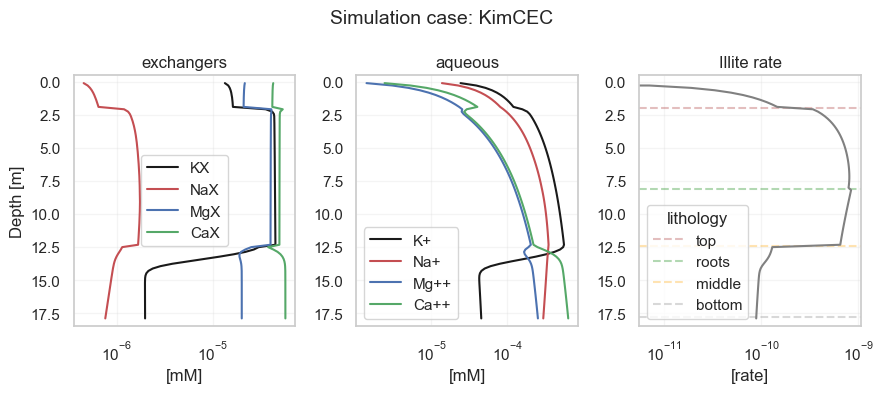

In [197]:
fig, axs = plt.subplots(1,3,figsize = (9,4))
# for case, label, color in zip(['dum-AqKin1.0E+07-KimCEC', 'dum-AqKin1.0E+07-BaseCase'], ['Kim', 'BaseCase'], ['r', 'k']):
for case, label in zip(['dum-AqKin1.0E+07-KimCEC'], ['KimCEC']):
    ax = axs[0]
    for spe, color in zip(['KXEel', 'NaXEel', 'MgXEel', 'CaXEel'], ['k', 'r', 'b', 'g']):
        df_aux = dfs_output[case]['exchange']
        label_legend = spe[:-3]
        ax.plot(df_aux[spe], df_aux['Distance'], label = f'{label_legend}', color = color)
        ax.set(ylim = (18.5, -0.5), ylabel = 'Depth [m]', title = 'exchangers', xscale = 'log', xlabel = '[mM]')
        ax.legend()
        
    ax = axs[1]
    for spe, color in zip(['K+', 'Na+', 'Mg++', 'Ca++'], ['k', 'r', 'b', 'g']):
        df_aux = dfs_output[case]['totcon']
        ax.plot(df_aux[spe], df_aux['Distance'], label = f'{spe}', color = color)
        ax.set(ylim = (18.5, -0.5), ylabel = '', title = 'aqueous', xscale = 'log', xlabel = '[mM]')
        ax.legend()
        
    ax = axs[2]
    df_aux = dfs_output[case]['rate']
    for domain_hzn, color, label_hzn in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
        ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3, label = label_hzn)
    ax.plot(df_aux['Illite'], df_aux['Distance'], color = color)
    ax.set(ylim = (18.5, -0.5), ylabel = '', title = 'Illite rate', xscale = 'log', xlabel = '[rate]')
    ax.legend(title = 'lithology')
    
    
# ax.legend(bbox_to_anchor = (1,1))
fig.suptitle(f'Simulation case: {label}')
fig.tight_layout()
plt.savefig('/Users/ivano/Documents/PostDoc-UIUC/Paper1/Manuscript/Figures/SI/SorbedPhases.png')

### Modified to plot all sensitivity cases

In [230]:
def find_case_name(fitting_case):
    for i in os.listdir(os.path.join(root, results_folder, fitting_case)):
        if 'BK_Tp_' in i: 
            case_name = i
            return case_name

In [236]:
working_folder = os.path.join(root, results_folder, 'Sim001')
dfs_output, BK_dict = dfs_output_fun_mod(working_folder, ['totcon', 'conc', 'gases'], 'Sim001')   

running function dfs_output_fun...


Auxiliar function to plot simulations with names Sim###

In [219]:
%matplotlib inline
sns.set_theme(style='whitegrid')

str_in_case = 'U_CECplot' #This is just in case I want to filter 
results_aux = ''
results_path = os.path.join('Fittings', results_aux)
results_folder = os.path.join('Fittings/1D_ResearchScenarios', results_aux)

try: 
    os.mkdir(os.path.join(MyFigures_root, results_path))
except: 
    pass

gas_out = 'gases' #gas or gases
vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate', 'AqRate', 'totexchange', 'exchange', gas_out]
VMS_choice = ['A', 'B']
output_times =  time_sim
    
# working_folder = os.path.join(root, results_folder, 'Sim001')
# dfs_output, BK_dict = dfs_output_fun_mod(working_folder, vars_to_assemble, case_name)    

def make_ivo_plots(myfun, export_label, fitting_case):
    fig, fitting_case, _iterated_param, _rock_domain, _initial_condition = myfun(vars_to_assemble, VMS_choice, output_times, gas_out, 
                                                                                 fitting_case, dfs_output, BK_dict)

    # try: 
    #     os.mkdir(os.path.join(MyFigures_root, results_path, fitting_case))
    # except: 
    #     pass

    print('exporting ', os.path.join(MyFigures_root, results_path, f'{fitting_case}.png'))
    fig.savefig(os.path.join(MyFigures_root, results_path, f'{fitting_case}.png'))
    plt.close()
    
    return _iterated_param, _rock_domain, fitting_case, _initial_condition
    
    
for fitting_case in os.listdir(os.path.join(root, results_folder)):
    if str_in_case in fitting_case: 
        for fun, export_label in zip([CarbonOxid, plot_sensitivity_results_Majors_mod_bis],
                                    ['CarbonOxid', 'Solutes']):
        # for fun, export_label in zip([plot_sensitivity_results_Minerals_mod, plot_sensitivity_results_Cox_mod, 
        #                               plot_sensitivity_results_Majors_mod, plot_sensitivity_results_Exchangers_mod],
        #                             ['MineralRates', 'CarbonOxid', 'Solutes', 'Exchangers']):

            _iterated_param, _rock_domain, fitting_case, _initial_condition = make_ivo_plots(fun, export_label, fitting_case)
            print('iterated_param = ',_iterated_param,'\nrock_domain = ', _rock_domain,'\nfitting_case = ', fitting_case, 
                 '\ninitial condition = ', _initial_condition)


NameError: name 'CarbonOxid' is not defined

### Plot single plot by iteration

In [137]:
gas_out = 'gases' #'gases' or 'gas'
vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate', 'AqRate', 'totexchange', gas_out, 'exchange']
VMS_choice = ['A', 'B']
output_times =  export_times+' '+ time_sim
output_times = [float(i) for i in output_times.split()]
rock_horizons = initial_conds[1:]
results_folder = 'Fittings/1D_ResearchScenarios'
# initial_condition = 'allRW'
for fitting_case in os.listdir(os.path.join(root, results_folder)):
    if 'A_NoCox' in fitting_case: 
        print('working on', fitting_case)
        _iterated_param = fitting_case.split('_')[1]

        working_folder = os.path.join(root, results_folder, fitting_case)

        df_VMS_dict = build_VMS_df(VMS_choice)

#-------- Finding the iterated variable to put in legend
        it_0 = []
        cont_cn = 0
        for case_name in os.listdir(os.path.join(root, results_folder, fitting_case)):
            if case_name == '.DS_Store':
                next
            else:
                it = []
                for cont, i in enumerate(split_with_exception(case_name, r'(?<!E)-')):
                    if cont_cn == 0:
                        it_0.append(i); it.append(i)
                    else:
                        it.append(i)
                for filename in os.listdir(os.path.join(root, results_folder, fitting_case, case_name)):
                    if 'Bkp' in filename:
                        _initial_condition = filename.split('-')[0][4:]
                        _rock_domain = filename.split('-')[4]
                print('Plotting', f'Domain: {_rock_domain}  -  Initial cond: {_initial_condition}')
                cont_cn += 1
        cont_cum = 0                
        for cont in range(len(it)):
            if it_0[cont] != it[cont]:
                position_itervar = cont
                cont_cum +=1
#------------------------------------------------              
        for case_name in os.listdir(os.path.join(root, results_folder, fitting_case)):
            if case_name == '.DS_Store':
                next
            else:
                if cont_cum == 0: #this happens when iteration is "unique"
                    legend_label = ''
                else:
                    legend_label = split_with_exception(case_name, r'(?<!E)-')[position_itervar]
                dfs_output, BK_dict = dfs_output_fun(working_folder, vars_to_assemble, case_name)

                nrows = 3
                ncols = 3
                fig, axs = plt.subplots(nrows, ncols, sharex = False, sharey = True, figsize = (4*ncols, 4*nrows)) 
                colrows = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [0,2], [1,2], [2,2]]
                for cont, spe in enumerate(['Na+', 'pH', 'K+', 'CH2O', 'SiO2(aq)', 'POMC', 'CO2(g)', 'O2(g)', 'POMC']):
                    row = colrows[cont][0]; col = colrows[cont][1]
                    ax = axs[row, col]
                    if spe == 'CH2O':
                        for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
                            ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3)#, label = 'bt_'+label)
                        for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
                            df = dfs_output[case_name]['totcon']
                            df_t = df.loc[df.time == t]
                            ax.plot(df_t[spe], df_t['Distance'], label = f'{t} yr', color = color)
                        ax.set_title(spe+' [M]') 
                    elif spe == 'pH':
                        for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
                            ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3)#, label = 'bt_'+label)
                        for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
                            df = dfs_output[case_name]['conc']
                            df_t = df.loc[df.time == t]
                            ax.plot(df_t[spe], df_t['Distance'], label = f'{t} yr', color = color)
                        ax.set_title(spe+' ') 
                    elif (spe == 'CO2(g)')|(spe == 'O2(g)'):
                        aux_gas = gas_tune_long.loc[gas_tune_long.gas == spe]
                        ax.plot(aux_gas['gas_pct'], aux_gas['Depth_m'], color = 'grey', alpha = 0.4, marker = 'o', linestyle = '')
                        for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
                            ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3)#, label = 'bt_'+label)
                        for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
                            df = dfs_output[case_name][gas_out]
                            df_t = df.loc[df.time == t]
                            ax.plot(df_t[spe]*100/1.013, df_t['Distance'], label = f'{t} yr', color = color)
                        ax.set_title(spe+' [%]') 
#-------- Mineral Rates ----------
                    elif cont == 5:
                        for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
                            ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3)#, label = 'bt_'+label)
                        for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
                            df = dfs_output[case_name]['MineralPercent']
                            df_t = df.loc[df.time == t]
                            ax.plot(df_t[spe], df_t['Distance'], label = f'{t} yr', color = color)
                        ax.set_title(spe+' [wt%]')
                    elif cont == 8:
                        for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
                            ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3)#, label = 'bt_'+label)
                        for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
                            df = dfs_output[case_name]['rate']
                            df_t = df.loc[df.time == t]
                            ax.plot(df_t[spe]*(-1), df_t['Distance'], label = f'{t} yr', color = color)
                        ax.set_title(spe+'x(-1) [Mol/$m^{3}_{pm}$/s]')
                    else: 
                        for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
                            ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.3)#, label = 'bt_'+label)
                        for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
                            df = dfs_output[case_name]['totcon']
                            df_t = df.loc[df.time == t]
                            ax.plot(df_t[spe]*1000, df_t['Distance'], label = f'{t} yr', color = color)
                        for VMS, marker in zip(VMS_choice, ['o', 'v']): 
                            ax.plot(df_VMS_dict[VMS][spe]['mean'], df_VMS_dict[VMS]['Distance'], label = f'VMS-{VMS}', marker = marker, linestyle = '', color = 'grey')
                            ax.errorbar(df_VMS_dict[VMS][spe]['mean'], df_VMS_dict[VMS]['Distance'], xerr=df_VMS_dict[VMS][spe]['std'], fmt='none', ecolor='black', capsize=5, alpha = 0.1)
                        ax.set_title(spe+' [mM]')

                    ax.set_ylim(18.9, -0.5); 
                    ax.set_xscale('linear') if spe in ['O2(g)', 'CO2(g)', 'POMC'] else ax.set_xscale('log')
                    ax.set_ylabel('Depth [m]') if col == 0 else next
                    ax.legend(bbox_to_anchor = (1.1, 1), loc = 2) if cont == 8 else next
                    row += 1; col += 1

                fig.suptitle(f'Domain: {_rock_domain}  -  Initial cond: {initial_condition}', fontsize = 12)
                fig.tight_layout()

                try: 
                    os.mkdir(os.path.join(MyFigures_root, 'Fittings', fitting_case))
                    # os.mkdir(os.path.join(MyFigures_root, 'Fittings', fitting_case, case_name))
                # except:
                #     try:
                #         os.mkdir(os.path.join(MyFigures_root, 'Fittings', fitting_case, case_name))
                except: 
                    pass

                print('exporting ', os.path.join(MyFigures_root, 'Fittings', fitting_case, f'Depth_profs_{initial_condition}_{_iterated_param}_{legend_label}.png'))
                plt.savefig(os.path.join(MyFigures_root, 'Fittings', fitting_case, f'Depth_profs_{initial_condition}_{_iterated_param}_{legend_label}.png'))
                plt.close()

working on A_NoCox
Plotting Domain: Sat_1R20  -  Initial cond: LastBatch
Plotting Domain: Sat_1R20  -  Initial cond: LastBatch
running function dfs_output_fun...
exporting  /Users/ivano/Library/CloudStorage/Box-Box/PostDoc-UIUC/Paper1/MyFigures/Crunch_Simulations/1D_VMS/Fittings/A_NoCox/Depth_profs_LastBatch_NoCox_AqKin1.0E+05.png
running function dfs_output_fun...
exporting  /Users/ivano/Library/CloudStorage/Box-Box/PostDoc-UIUC/Paper1/MyFigures/Crunch_Simulations/1D_VMS/Fittings/A_NoCox/Depth_profs_LastBatch_NoCox_AqKin1.0E-05.png


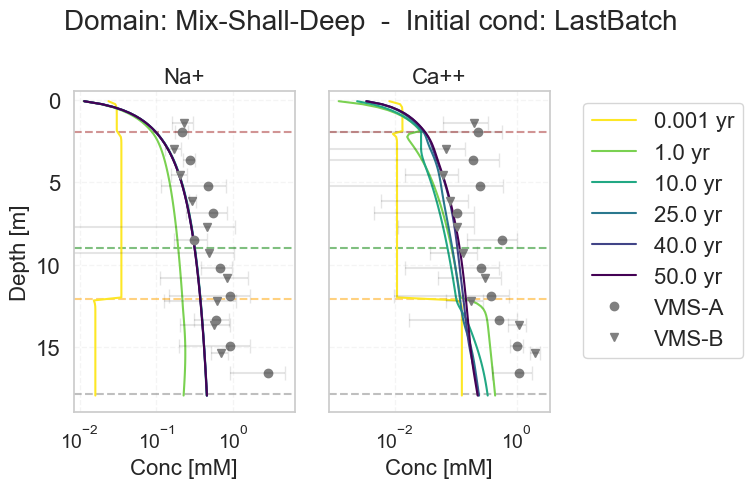

In [123]:
VMS_choice = ['A', 'B']
df_VMS_dict = build_VMS_df(VMS_choice)

s = export_times+' 50'
output_times = [float(item) for item in s.split()]

df = dfs_output[case_name]['totcon']

fig, axs = plt.subplots(1,2, sharex = False, sharey = True, figsize = (4*2, 5)) 
for cont, spe in enumerate(['Na+', 'Ca++']):
    ax = axs[cont]
    for domain_hzn, color, label in zip(np.dot(domain_limits, grid_dx), ['brown', 'green', 'orange', 'grey'], rock_horizons):
        ax.axhline(domain_hzn, color = color, linestyle = '--', alpha = 0.5)#, label = 'bt_'+label)
    for t, color in zip(output_times, create_color_list(output_times, 'viridis')[::-1]): 
        df_t = df.loc[df.time == t]
        ax.plot(df_t[spe]*1000, df_t['Distance'], label = f'{t} yr', color = color)
    for VMS, marker in zip(VMS_choice, ['o', 'v']): 
        ax.plot(df_VMS_dict[VMS][spe]['mean'], df_VMS_dict[VMS]['Distance'], label = f'VMS-{VMS}', marker = marker, linestyle = '', color = 'grey')
        ax.errorbar(df_VMS_dict[VMS][spe]['mean'], df_VMS_dict[VMS]['Distance'], xerr=df_VMS_dict[VMS][spe]['std'], fmt='none', ecolor='black', capsize=5, alpha = 0.1)
    ax.set_ylim(18.9, -0.5); ax.set_title(spe); ax.set_xscale('log')
    ax.set_ylabel('Depth [m]') if cont == 0 else next
    ax.set_xlabel('Conc [mM]')
    ax.legend(bbox_to_anchor = (1.1, 1), loc = 2) if cont == 1 else next
fig.suptitle(f'Domain: {Rock_domain}  -  Initial cond: {initial_condition}')
fig.tight_layout()

### Plot Minerals depth profile

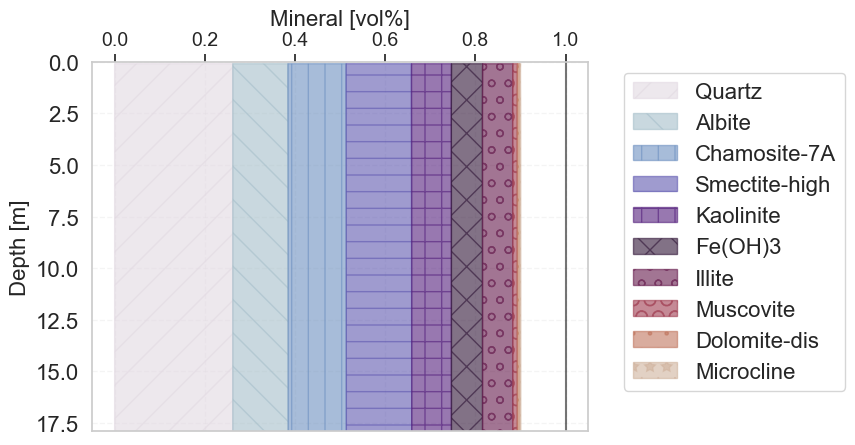

In [125]:
df = dfs_output[case_name]['volume']
df_t = df.loc[df.time == 50]
df_t = df_t.loc[:, ['Distance']+minerals_names]
columns_order = ['Quartz', 'Albite', 'Chamosite-7A', 'Smectite-high', 'Kaolinite', 'Fe(OH)3', 'Illite', 'Muscovite', 'Dolomite-dis', 'Microcline', 'POMC']

######### DATA WRANGLING ##############
df_t = df_t.loc[:,['Distance']+columns_order]
df_t = df_t.reset_index(drop = True)
df_t = df_t.set_index('Distance')

cum_df = df_t.copy()
for k in range(len(df_t.columns)):
    if k == 0:
        aux = cum_df.iloc[:,k]/100
    else:
        aux = cum_df.iloc[:,k-1]+(cum_df.iloc[:,k])/100
        
    cum_df.iloc[:,k] = aux
    
cum_df = cum_df.assign(porosity = lambda x: 1-x.POMC)
cum_df = cum_df.reset_index(drop = False)
#-----------------------------------------------
######### PLOTTING ##############

colors = create_color_list(columns_order, 'twilight')
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
alpha = 0.6
cont = 0
for spe, color, hatch in zip(columns_order, colors, hatches):
    # plt.plot(cum_df[spe], cum_df['Distance'], label = spe, color = color, alpha = 0.5)
    if cont == 0:
        plt.fill_betweenx(y = cum_df['Distance'], x1=0, x2=cum_df[spe], color = color, hatch = hatch, label = spe, alpha = alpha)
        prev_spe = spe
    else:
        plt.fill_betweenx(y = cum_df['Distance'], x1=cum_df[prev_spe], x2=cum_df[spe], color = color, hatch = hatch, label = spe, alpha = alpha)
        prev_spe = spe
    cont += 1
plt.axvline(x=1, color = 'k', alpha = alpha)

plt.ylim(17.91, 0); plt.xlim(-0.05, 1.05)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2) 
plt.ylabel('Depth [m]'), plt.xlabel('Mineral [vol%]')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
# plt.yscale('log')
plt.show()

In [ ]:
# FLUSHING PLOT
fig, ax = plt.subplots(figsize = (4,3))
df = dfs_output['RW-rt_Ab_SSA-1.0E+00']['totcon']
df = df.loc[df.Distance == 17.91]
ax.plot(df['time'], df['Tracer']*1000, 'o-')
ax.set_yscale('log'), ax.set_xscale('log'),
ax.set_title('Domain-flushing plot')
ax.set_ylabel('Conc [mM]'); ax.set_xlabel('time [y]')
fig.tight_layout()

-------------

# Jon Results to compare

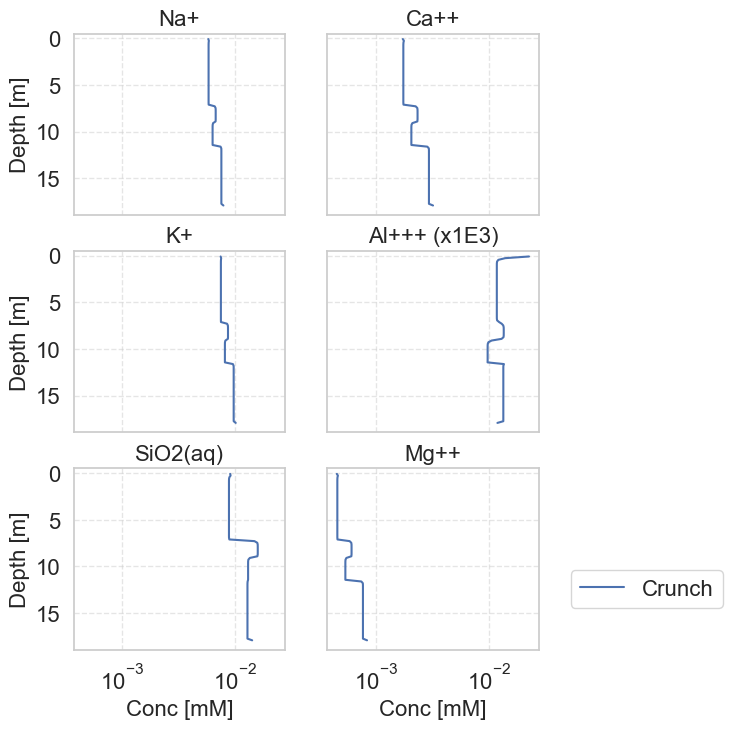

In [ ]:
df = pd.read_table(os.path.join(root, 'OriginalJiaFiles/totcon1.out'), skiprows = 2, sep = '\s+')

fig, axs = plt.subplots(3,2, sharex = True, sharey = True, figsize = (2*3, 4*2)) 
colrows = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]]
for cont, spe in enumerate(['Na+', 'Ca++', 'K+', 'Al+++', 'SiO2(aq)', 'Mg++']):
    row = colrows[cont][0]; col = colrows[cont][1]
    ax = axs[row, col]
    # ax.plot(df[spe]*1000, df['Distance'], label = 'Crunch')
    # next if spe == 'Al+++' else ax.plot(df_field[spe]['mean'], df_field['Distance'], label = 'VMS-A', marker = 'o', linestyle = '', color = 'grey')
    if spe == 'Al+++':
        ax.plot(df[spe]*1000000, df['Distance'], label = 'Crunch')
        ax.set_title(spe+' (x1E3)') 
    else: 
        ax.plot(df[spe]*1000, df['Distance'], label = 'Crunch')
        ax.set_title(spe)
        
    ax.set_ylim(18.9, -0.5); ax.set_xscale('log'); ax.grid(linestyle = '--', alpha = 0.5)
    ax.set_ylabel('Depth [m]') if col == 0 else next
    ax.set_xlabel('Conc [mM]') if row == 2 else next
    ax.legend(bbox_to_anchor = (1.1, 0.5), loc = 2) if cont == 5 else next
    row += 1; col += 1

---------------------------------------------

# Plots for 1D model

In [17]:
regions = ['top', 'middle', 'bottom']
dfs_list = []
for region in regions:
    aux = pd.read_table(os.path.join(root, 'Run_Verification','%s.txt'%region), skiprows = 2, header=None, sep = '\s+', engine = 'python', names = variables)
    dfs_list.append(aux)

dfs_dict = dict(zip(regions, dfs_list))

Plot of iron ts from different regions

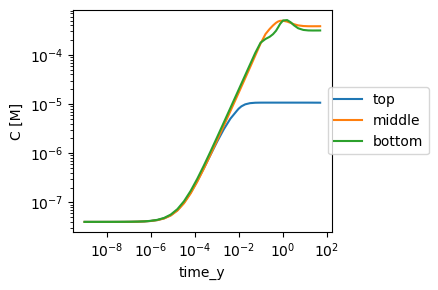

In [19]:
fig, ax = plt.subplots(figsize = (5,3))
species = 'Fe++'
for region in regions: 
    df = dfs_dict[region]
    sns.lineplot(x='time_y', y=species, data=df, ax=ax, label=region)
    ax.legend(bbox_to_anchor = (1.4,0.5), loc = 'center right')
    ax.set_ylabel('C [M]'); #ax2.set_ylabel('O2(aq)')
    ax.set_xscale('log')
    ax.set_yscale('log'); #ax2.set_yscale('log')

title = species+'_ts'
fig.tight_layout()
# plt.savefig(os.path.join(export_folder, 'Sim_1D', 'No_Fe_oxidation', title+'.png'))

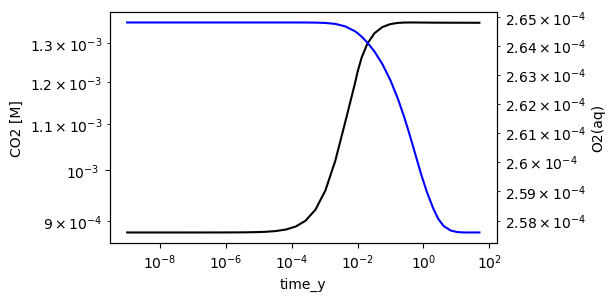

In [62]:
fig, ax = plt.subplots(figsize = (5,3))
species = ['CO2(aq)', 'O2(aq)']
sns.lineplot(x='time_y', y=species[0], data=df, ax=ax, color = 'k')
ax2 = ax.twinx()
sns.lineplot(x='time_y', y=species[1], data=df, ax=ax2, color = 'b')
# ax.legend(bbox_to_anchor = (1.4,0.5), loc = 'center right')
ax.set_ylabel('CO2 [M]'); ax2.set_ylabel('O2(aq)')
ax.set_xscale('log')
ax.set_yscale('log'); ax2.set_yscale('log')
# fig.show()

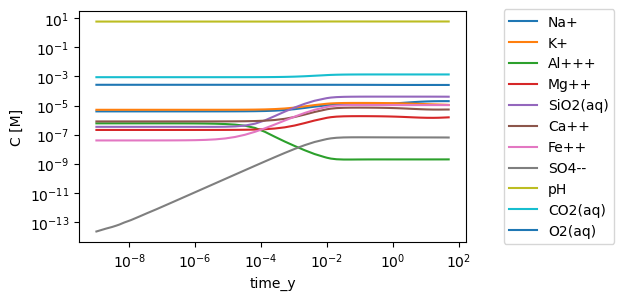

In [54]:
fig, ax = plt.subplots(figsize = (5,3))
species = ["Na+", "K+", "Al+++", "Mg++", "SiO2(aq)", "Ca++", "Fe++", "SO4--", "pH", "CO2(aq)", "O2(aq)"]
for plot_var in species: #['Na+', 'K+','Fe++']
    ax= sns.lineplot(x='time_y', y=plot_var, data=df, label=plot_var)
ax.legend(bbox_to_anchor = (1.4,0.5), loc = 'center right')
ax.set_ylabel('C [M]')
ax.set_xscale('log')
ax.set_yscale('log')
# fig.show()

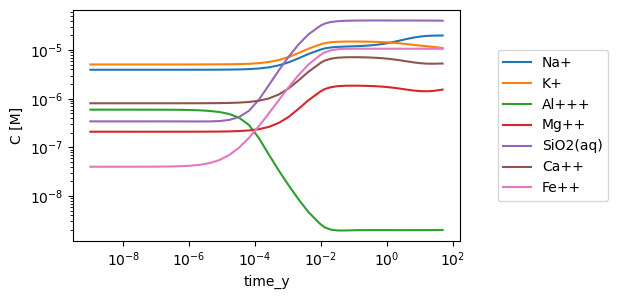

In [67]:
fig, ax = plt.subplots(figsize = (5,3))
species = ["Na+", "K+", "Al+++", "Mg++", "SiO2(aq)", "Ca++", "Fe++"]
for plot_var in species: #['Na+', 'K+','Fe++']
    ax= sns.lineplot(x='time_y', y=plot_var, data=df, label=plot_var)
ax.legend(bbox_to_anchor = (1.4,0.5), loc = 'center right')
ax.set_ylabel('C [M]')
ax.set_xscale('log')
ax.set_yscale('log')
# fig.show()

------------------------------------------

## Test Function for optimization

Class crunch definition

In [8]:
class Crunch_class:
    ############################
    ## Ceci est pour créer des variables qui seraient communes à toute la class
    # def __init__(self):        
    #     self.root = 'D:/BKP_ordi_These/PostDoc/Paper1/CrunchModels/BatchOptimization'
#-------------------------------------------------------------------

#-------------------------------------------------------------------
    def join_model_to_lab_data(self, show_check_plot, export_check_plot, spe_for_plot):
        mse_list = []
        for spe in aqueous_to_plot: 
            if isinstance(self.BK_df, dict):
                subsampled_dict = {key: value for key, value in self.BK_df.items() if Rock_type in key}
                df1 = subsampled_dict[self.case_name]
            else: 
                df1 = self.BK_df
            df1 = df1.loc[:,['time', spe]].reset_index(drop = True)

            df2 = batch_exp_df.loc[batch_exp_df.Group == self.Rock_type_aux].reset_index(drop = True)
            df2 = df2.loc[:,['Cum_hours', spe]]
            df2.columns = ['time', spe]

            df2['time'] = df2['time'].round(3)

            # Create a list to store DataFrames to concatenate
            dfs_to_concat = []

            # Iterate over each timestamp in dataframe 2
            for index, row in df2.iterrows():
                time2 = row['time']
                # Check if the timestamp exists in dataframe 1
                if time2 not in df1['time'].values:
                    # Find the two closest timestamps in dataframe 1
                    idx = df1['time'].sub(time2).abs().idxmin()
                    prev_time = df1.loc[idx, 'time']
                    next_time = df1.loc[idx + 1, 'time']
                    # Interpolate the corresponding "Var" value
                    interpolated_var = np.interp(time2, [prev_time, next_time],
                                                  [df1.loc[idx, spe], df1.loc[idx + 1, spe]])
                    # Create a DataFrame for the new row
                    new_row = pd.DataFrame({'time': [time2], spe: [interpolated_var]})
                    # Append the new DataFrame to the list
                    dfs_to_concat.append(new_row)

            # Concatenate the list of DataFrames with dataframe 1
            if dfs_to_concat:
                df1 = pd.concat([df1] + dfs_to_concat, ignore_index=True)

            df1 = df1.sort_values(by = 'time')
            # Merge the two dataframes using the time column as the key
            merged_df = pd.merge(df1, df2, on='time', suffixes=('_sim', '_batch'))
            merged_df.columns = ['time', 'model', 'lab']
            merged_df = merged_df.sort_values(by = 'time')

            # Compute mean squared error
            corr_factor = 1 if spe == 'pH' else 1000
            mse_spe = np.mean((merged_df['model']*corr_factor - merged_df['lab']) ** 2)
            mse_list.append(mse_spe)
                #---------------------------------------
            if spe == spe_for_plot:
                fig, ax = plt.subplots(figsize = (5,4))
                ax.plot(df2.time, df2[spe_for_plot], 'o', label = 'Lab')
                ax.plot(df1.time, df1[spe_for_plot]*1000, '-r', marker = 's', label = 'Simulated')
                ax.plot(merged_df.time, merged_df['model']*1000, '--k', marker = 'v', label = 'Sim_Interpoltd')
                ax.set_xlabel('time [h]'); ax.set_ylabel(f'{spe_for_plot} [mM]')
                ax.legend(); ax.set_title(f'{self.case_name}\nMSE = {mse_spe: .3E} $mM^2$ -- RMSE = {np.sqrt(mse_spe): .3E} mM')
                fig.tight_layout()
                plt.savefig(os.path.join(self.path_results, f'CheckPlotMSE_{self.case_name}.png')) if export_check_plot == True else next

                plt.show() if show_check_plot == True else plt.close()

        mse_df = pd.DataFrame([mse_list], columns = aqueous_to_plot)
        total_mse_case = mse_df.sum(axis = 1)[0]
        mse_target = mse_df[target_for_mse].sum(axis=1)[0]
        aux_MineralCompo = Minerals_sweep.loc[Minerals_sweep.Mineral == Mineral_for_sensitivity, self.Rock_type].values[0]
        mse_df.insert(0, 'Rock_type', self.Rock_type)
        mse_df.insert(0, minerals_abb_dict[Mineral_for_sensitivity], aux_MineralCompo)
        mse_df.insert(0, 'Initial_cond', self.initial_cond)
        # print(f'total mse computed for: {self.tested_param_text}\nTarget mse {target_for_mse}: {mse_target}')
        mse_df.insert(0, f'{tested_param}', self.iter_var)

        return merged_df, df1, df2, total_mse_case, mse_target, mse_df    
#-------------------------------------------------------------------
    def optimize_crunch_case(self, arr_tested_param, export_spatial_profile = False, erase_previous = True):   
        # Normally don't need to touch it
        vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate']
        
        time_sim = '260' # simulation time in hours
        time_sim_subdiv = '1 5 10 20 30 40 50 70 90 110 130 200 230' if export_spatial_profile == True else ''
        
        mse_df = pd.DataFrame()
        
        # CREATE results folder-----------------------------
        self.path_results = os.path.join(root, export_folder, fitting_case) # Update result's folder name
        try:
            os.mkdir(self.path_results)
        except OSError:
            next
        else:
            print(f'Creating {self.path_results}')

        if erase_previous == True:
            print(f'Clearing results folder... {fitting_case}')
            clear_folder(self.path_results) #Erase old results in the results folder if any

        #--------------------------
        ##########################################
        ##### Compile lab experiments data
        ##########################################
        print('\nCompiling experimental results for reference...\n')
        self.dfs_output_jia, self.BK_dict_jia = dfs_output_fun(os.path.join(root_jia_model, results_folder_jia_model) , vars_to_assemble)

        print('Iterations begin...')
        #--------------------------
        ##########################################
        ##### ITERATION
        ##########################################
        # Find the iteration row in input_file depending on the iterated variable.
        if tested_param == 'SSA':
            iter_row = find_iter_row_in_input_file(Mineral_for_sensitivity, aux_min_cond, aux_min)
        elif (tested_param == 'VolPct')|(tested_param == ''):
            next
        elif tested_param == 'AqComp':
            iter_row = find_iter_row_in_input_file(Mineral_for_sensitivity, aux_aq_cond, aux_min_cond)
            
        for self.initial_cond in initial_conds:
            for self.Rock_type in Rock_types: # To iterate over the different rock compositions
                #################################
                ## SENSITIVITY
                for self.iter_var in arr_tested_param:
                #################################
                    Sim_results = pd.DataFrame()        
                    row = 0
                    #--------------------------------------------------
                    try: 
                        self.tested_param_text = f'{minerals_abb_dict[Mineral_for_sensitivity]}_{tested_param}' 
                    except: 
                        self.tested_param_text = f'{Mineral_for_sensitivity}_{tested_param}'

                    self.case_name = f'{self.initial_cond}-{self.Rock_type}-{self.tested_param_text}' if self.iter_var == '' else f'{self.initial_cond}-{self.Rock_type}-{self.tested_param_text}-{self.iter_var:.1E}' 

                    # OPEN input file for EDITING
                    with open(os.path.join(root, input_file), 'r') as fp:
                        data =  fp.readlines()

                    # CREATE results folder-----------------------------
                    path_results_case = os.path.join(root, export_folder, fitting_case , self.case_name) # Update result's folder name
                    try:
                        print(f'Creating {path_results_case}')
                        os.mkdir(path_results_case)
                    except OSError:
                        next # print('Directory already exists')
                    else:
                        next # print('Directory successfully created')

                    data[1] = str('Ivan - Kinetic dissolution of %s\n' % self.Rock_type) 
                    data[19] = str('database             %s\n')%DBS_name  
                    self.Rock_type_aux = 'Deep' if 'Deep' in self.Rock_type else self.Rock_type
                    data[22] = str('Fix_saturation       %s\n')%moisture_dict[self.Rock_type_aux] 
                    data[25] = str('OUTPUT\n') ; row += 1 ############# OUTPUT ################################
                    if export_spatial_profile == True:                        
                        data[27] = str('spatial_profile       '+time_sim_subdiv+' '+time_sim+'\n') #le numéro est la quantité d'années qu'on laisse pour la dissolution
                    else:
                        data[27] = str('spatial_profile       '+time_sim_subdiv+' '+time_sim+'\n')  #le numéro est la quantité d'années qu'on laisse pour la dissolution
                    data[28] = str('time_series           BK_'+self.case_name+'.out  1 1 1\n') 
                    data[29] = str('time_series_print     Na+ K+ Al+++ Mg++ SiO2(aq) Ca++ Fe++ SO4-- pH CO2(aq) O2(aq)\n')
                    data[43] = str('x_begin     %s       dirichlet\n'%self.initial_cond) 
                    data[44] = str('x_end     %s       dirichlet\n'%self.initial_cond)

                    # SECONDARY SPECIES SECTION
                    write_input_list(data, data_list = Secondary_sweep, key = 'Species', cont = aux_second, rock_type = self.Rock_type_aux) #aux_moisture defined above in the moisture input
                    # MINERALS KINETIC SECTION
                    write_input_list(data, data_list = Kinetic_sweep, key = 'Kinetic', cont = aux_min, rock_type = self.Rock_type_aux)
                    # MINERALS COMPOSITION SECTION
                    write_input_list(data, data_list = Minerals_dict, key = 'Mineral', cont = aux_min_cond, rock_type = self.Rock_type)
                    data[87] = str(f'XEel-                        -cec    {CEC_dict[self.Rock_type_aux]}\n') ; row += 1            
                    # AQUEOUS CONDITION
                    with open(os.path.join(root, input_file)) as fp:
                        for cnt, line in enumerate(fp):
                            if 'INITIAL_CONDITIONS' in line: data[cnt+1] = f'{self.initial_cond}       1-10 1-1 1-1\n'
                            if 'Condition ' in line: data[cnt] = f'Condition   {self.initial_cond}   \n'
                    write_input_comp(data, df_comp = Aqueous_input, key = 'Var', cont = aux_aq_cond, col = self.initial_cond)

                    #############################################################################
                    ############# ITERATION PARAMETER ##########
                    #############################################################################            
                    if tested_param == 'SSA':
                        min_vol_pct = Minerals_sweep.loc[Minerals_sweep.Mineral == Mineral_for_sensitivity, self.Rock_type].values[0]
                        data[iter_row] = str(f'{Mineral_for_sensitivity}                             {min_vol_pct} specific_surface_area {self.iter_var:.3E}\n') ; row += 1
                    elif (tested_param == 'VolPct')|(tested_param == ''): 
                        next # The sensitivity is made with the mineral composition input file
                    elif tested_param == 'AqComp': 
                        data[iter_row] = str(f'{Mineral_for_sensitivity}           {self.iter_var:.3E}\n') ; row += 1
                    elif tested_param == 'PCO2':
                        # data[iter_row] = str(f'CO2(aq)    CO2(g)  {iter_var:.3E}\n') ; row += 1
                        print('***********Check the iteration block to verify what I am iterating....***************')  
                    else:
                        print('***********Check the iteration block to verify what I am iterating....***************')                    
                    #############################################################################

                    with open(os.path.join(root, input_file), 'w') as fp:
                        fp.writelines(data)

                    ###############################################################################
                    ###### RUN SIMULATION
                    ###############################################################################
                    print('Launching %s simulation'%(self.Rock_type))
                    # print('running %s'%os.path.join(root, input_file))
                    Crunch_run = S.run([os.path.join(root, 'CrunchTope-64bit.exe'), os.path.join(root, input_file)])
                    if Crunch_run.returncode == 0 :                 
                    #### Move output files to their corresponding folders
                        move_crunch_outputs(root, path_results_case, input_file, self.case_name, DBS_name)
                    else:
                        print('***********error in simulation**************') 
                        error_cases.append(self.case_name) #Append the casename to the list containing the cases with problems

                    ##########################################
                    ##### Compile iteration results
                    ##########################################
                    self.BK_df = compile_single_BK_case(root, export_folder, fitting_case, self.case_name)
                    # Function to create a df with both lab and model data
                    merged_df, df_model, df_lab, total_mse, mse_target, mse_aux_iter = self.join_model_to_lab_data(show_check_plot = False, export_check_plot = False, spe_for_plot = 'Na+')
                    print(f'total MSE = {total_mse:.3E}\ntarget MSE for {target_for_mse} = {mse_target:.3E}')
                    # Compile the optimization process
                    mse_df = pd.concat([mse_df, mse_aux_iter])
        return mse_target, mse_df, self.BK_dict_jia, self.path_results, self.case_name

Class with DOUBLE ITERATION

In [9]:
class Crunch_class_double_iter:
    ############################
    ## Ceci est pour créer des variables qui seraient communes à toute la class
    # def __init__(self):        
    #     self.root = 'D:/BKP_ordi_These/PostDoc/Paper1/CrunchModels/BatchOptimization'
#-------------------------------------------------------------------

#-------------------------------------------------------------------
    def join_model_to_lab_data(self, show_check_plot, export_check_plot, spe_for_plot):
        mse_list = []
        for spe in aqueous_to_plot: 
            if isinstance(self.BK_df, dict):
                subsampled_dict = {key: value for key, value in self.BK_df.items() if self.Rock_type in key}
                df1 = subsampled_dict[self.case_name]
            else: 
                df1 = self.BK_df
            df1 = df1.loc[:,['time', spe]].reset_index(drop = True)

            df2 = batch_exp_df.loc[batch_exp_df.Group == self.Rock_type_aux].reset_index(drop = True)
            df2 = df2.loc[:,['Cum_hours', spe]]
            df2.columns = ['time', spe]

            df2['time'] = df2['time'].round(3)

            # Create a list to store DataFrames to concatenate
            dfs_to_concat = []

            # Iterate over each timestamp in dataframe 2
            for index, row in df2.iterrows():
                time2 = row['time']
                # Check if the timestamp exists in dataframe 1
                if time2 not in df1['time'].values:
                    try: 
                        # Find the two closest timestamps in dataframe 1
                        idx = df1['time'].sub(time2).abs().idxmin()
                        prev_time = df1.loc[idx, 'time']
                        next_time = df1.loc[idx + 1, 'time']
                        # Interpolate the corresponding "Var" value
                        interpolated_var = np.interp(time2, [prev_time, next_time],
                                                      [df1.loc[idx, spe], df1.loc[idx + 1, spe]])
                        # Create a DataFrame for the new row
                        new_row = pd.DataFrame({'time': [time2], spe: [interpolated_var]})
                        # Append the new DataFrame to the list
                        dfs_to_concat.append(new_row)
                    except:
                        next

            # Concatenate the list of DataFrames with dataframe 1
            if dfs_to_concat:
                df1 = pd.concat([df1] + dfs_to_concat, ignore_index=True)

            df1 = df1.sort_values(by = 'time')
            # Merge the two dataframes using the time column as the key
            merged_df = pd.merge(df1, df2, on='time', suffixes=('_sim', '_batch'))
            merged_df.columns = ['time', 'model', 'lab']
            merged_df = merged_df.sort_values(by = 'time')

            # Compute mean squared error
            corr_factor = 1 if spe == 'pH' else 1000
            mse_spe = np.mean((merged_df['model']*corr_factor - merged_df['lab']) ** 2)
            mse_list.append(mse_spe)
                #---------------------------------------
            if spe == spe_for_plot: #make the verification plot for the spe specified in the function input
                fig, ax = plt.subplots(figsize = (5,4))
                ax.plot(df2.time, df2[spe_for_plot], 'o', label = 'Lab')
                ax.plot(df1.time, df1[spe_for_plot]*1000, '-r', marker = 's', label = 'Simulated')
                ax.plot(merged_df.time, merged_df['model']*1000, '--k', marker = 'v', label = 'Sim_Interpoltd')
                ax.set_xlabel('time [h]'); ax.set_ylabel(f'{spe_for_plot} [mM]')
                ax.legend(); ax.set_title(f'{self.case_name}\nMSE = {mse_spe: .3E} $mM^2$ -- RMSE = {np.sqrt(mse_spe): .3E} mM')
                fig.tight_layout()
                plt.savefig(os.path.join(self.path_results, f'CheckPlotMSE_{self.case_name}.png')) if export_check_plot == True else next

                plt.show() if show_check_plot == True else plt.close()

        mse_df = pd.DataFrame([mse_list], columns = aqueous_to_plot)
        total_mse_case = mse_df.sum(axis = 1)[0]
        mse_target = mse_df[target_for_mse].sum(axis=1)[0]
        mse_df.insert(0, 'Rock_type', self.Rock_type)
        # print(f'total mse computed for: {self.tested_param_text}\nTarget mse {target_for_mse}: {mse_target}')
        mse_df.insert(0, f'{tested_param}_{Mineral_for_sensitivity}', self.iter_var)
        mse_df.insert(0, f'{tested_param2}_{Mineral_for_sensitivity2}', self.iter_var2) if ~(self.iter_var2 == 'U') else next 

        return merged_df, df1, df2, total_mse_case, mse_target, mse_df    
#-------------------------------------------------------------------
    def optimize_crunch_case(self, arr_tested_param, arr_tested_param2, export_spatial_profile = False, erase_previous = True):   
        # Normally don't need to touch it
        vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate']
        
        time_sim = '260' # simulation time in hours
        time_sim_subdiv = '1 5 10 50 70 90 110 120 130 140 200 230' if export_spatial_profile == True else ''
        
        mse_df = pd.DataFrame()
        
        # CREATE results folder-----------------------------            
        try: #To write something like Dol_SSA for Dolimite tested on SSA
            self.tested_param_text = f'{minerals_abb_dict[Mineral_for_sensitivity]}'  
        except: 
            self.tested_param_text = f'{Mineral_for_sensitivity}'

        try:
            self.tested_param_text2 = f'{minerals_abb_dict[Mineral_for_sensitivity2]}' 
        except: 
            self.tested_param_text2 = f'{Mineral_for_sensitivity2}'            
        
        self.fitting_case = f'{fitting_aux}_{self.tested_param_text}_{self.tested_param_text2}_{iteration}'#        
        self.path_results = os.path.join(root, export_folder, self.fitting_case) # Update result's folder name
        
        try:
            os.mkdir(self.path_results)
        except OSError:
            next
        else:
            print(f'Creating {self.path_results}')

        if erase_previous == True:
            print(f'Clearing results folder... {self.fitting_case}')
            clear_folder(self.path_results) #Erase old results in the results folder if any

        #--------------------------
        ##########################################
        ##### Compile lab experiments data
        ##########################################
        print('\nCompiling experimental results for reference...\n')
        self.dfs_output_jia, self.BK_dict_jia = dfs_output_fun(os.path.join(root_jia_model, results_folder_jia_model) , vars_to_assemble)

        print('Iterations begin...')
        #--------------------------
        ##########################################
        ##### ITERATION
        ##########################################
        # Find the iteration row in input_file depending on the iterated variable.
        iter_row = self.find_iter_row_for_tested_param(tested_param, Mineral_for_sensitivity)
        if tested_param2 == 'U':
            iter_row2 = 'U'
        else:
            iter_row2 = self.find_iter_row_for_tested_param(tested_param2, Mineral_for_sensitivity2)  
            
        print(f'for {tested_param}, iter_row = {iter_row}\nfor {tested_param2}, iter_row = {iter_row2}\n')
            
        for initial_cond in initial_conds:
            for self.Rock_type in Rock_types: # To iterate over the different rock compositions
                #################################
                ## SENSITIVITY
                for self.iter_var in arr_tested_param:
                    for self.iter_var2 in arr_tested_param2:
                #################################
                        Sim_results = pd.DataFrame()        
                        row = 0
                        #--------------------------------------------------
                        if tested_param2 == 'U':
                            self.case_name = f'{initial_cond}-{self.Rock_type}-{self.tested_param_text}_{tested_param}-{self.iter_var:.1E}' 
                        else:
                            self.case_name = f'{initial_cond}-{self.Rock_type}-{self.tested_param_text}_{tested_param}-{self.iter_var:.1E}_{self.tested_param_text2}_{tested_param2}-{self.iter_var2:.1E}' 

#-----------------------OPEN input file for EDITING
                        with open(os.path.join(root, input_file), 'r') as fp:
                            self.data =  fp.readlines()

#-----------------------CREATE results folder-----------------------------
                        self.path_results_case = os.path.join(root, export_folder, self.fitting_case , self.case_name) # Update result's folder name
                        try:
                            print(f'Creating {self.path_results_case}')
                            os.mkdir(self.path_results_case)
                        except OSError:
                            next # print('Directory already exists')
                        else:
                            next # print('Directory successfully created')

                        self.data[1] = str('Ivan - Kinetic dissolution of %s\n' % self.Rock_type) 
                        self.data[19] = str('database             %s\n')%DBS_name 
                        
                        if 'Deep' in self.Rock_type: 
                            self.Rock_type_aux = 'Deep'
                        elif 'Middle' in self.Rock_type:
                            self.Rock_type_aux = 'Middle'
                        elif 'Shallow' in self.Rock_type: 
                            self.Rock_type_aux = 'Shallow'
                        else:
                            next
                        
                        self.data[22] = str('Fix_saturation       %s\n')%moisture_dict[self.Rock_type_aux] 
                        self.data[25] = str('OUTPUT\n')  ############# OUTPUT ################################
                        if export_spatial_profile == True:                        
                            self.data[27] = str('spatial_profile       '+time_sim_subdiv+' '+time_sim+'\n')  #le numéro est la quantité d'années qu'on laisse pour la dissolution
                        else:
                            self.data[27] = str('spatial_profile       '+time_sim_subdiv+' '+time_sim+'\n')  #le numéro est la quantité d'années qu'on laisse pour la dissolution
                        self.data[28] = str('time_series           BK_'+self.case_name+'.out  1 1 1\n') 
                        self.data[29] = str('time_series_print     Na+ K+ Al+++ Mg++ SiO2(aq) Ca++ Fe++ SO4-- pH CO2(aq) O2(aq)\n')
                        
                        self.data[43] = str(f'x_begin     {initial_cond}       dirichlet\n')
                        self.data[44] = str(f'x_end     {initial_cond}       dirichlet\n')
                        
#-----------------------SECONDARY SPECIES SECTION
                        write_input_list(self.data, data_list = Secondary_sweep, key = 'Species', cont = aux_second, rock_type = self.Rock_type_aux) #aux_moisture defined above in the moisture input
#-----------------------MINERALS KINETIC SECTION
                        write_input_list(self.data, data_list = Kinetic_sweep, key = 'Kinetic', cont = aux_min, rock_type = self.Rock_type_aux)
#-----------------------MINERALS COMPOSITION SECTION
                        write_input_list(self.data, data_list = Minerals_dict, key = 'Mineral', cont = aux_min_cond, rock_type = self.Rock_type)
                        if tested_param == 'CEC':
                            self.data[89] = str(f'XEel-                        -cec    {self.iter_var:.3E}\n')
                        else:
                            self.data[89] = str(f'XEel-                        -cec    {CEC_dict[self.Rock_type_aux]}\n')         
                            
#-----------------------AQUEOUS CONDITION
                        with open(os.path.join(root, input_file)) as fp:
                            for cnt, line in enumerate(fp):
                                if 'INITIAL_CONDITIONS' in line: self.data[cnt+1] = f'{initial_cond}       1-10 1-1 1-1\n'
                                if 'Condition ' in line: self.data[cnt] = f'Condition   {initial_cond}   \n'
                        write_input_comp(self.data, df_comp = Aqueous_input, key = 'Var', cont = aux_aq_cond, col = initial_cond)

                        #############################################################################
#-----------------------############# ITERATION PARAMETER ##########
                        #############################################################################            
                        self.write_iteration_parameter(Mineral_for_sensitivity, tested_param, iter_row, self.iter_var)
                        self.write_iteration_parameter(Mineral_for_sensitivity2, tested_param2, iter_row2, self.iter_var2) if ~(self.iter_var2 == 'U') else next 
                        #############################################################################

                        with open(os.path.join(root, input_file), 'w') as fp:
                            fp.writelines(self.data)

                        ###############################################################################
#-----------------------###### RUN SIMULATION
                        ###############################################################################
                        if self.iter_var2 == 'U':
                            print(f'Launching {self.Rock_type} simulation with {tested_param} = {self.iter_var:1E}')
                        else:
                            print(f'Launching {self.Rock_type} simulation with {tested_param} = {self.iter_var:1E} and {tested_param2} = {self.iter_var2:1E}')
                        # print('running %s'%os.path.join(root, input_file))
                        Crunch_run = S.run([os.path.join(root, 'CrunchTope-64bit.exe'), os.path.join(root, input_file)])
                        if Crunch_run.returncode == 0 :                 
                        #### Move output files to their corresponding folders
#--------!!####!!-------#If any problem with this function, is probably that paths are too long because of long filenames#---------------------#
                            self.move_crunch_outputs(root, input_file, DBS_name)
                        else:
                            print('***********error in simulation**************') 
                            error_cases.append(self.case_name) #Append the casename to the list containing the cases with problems

                        ##########################################
#-----------------------##### Compile iteration results
                        ##########################################
                        self.BK_df = compile_single_BK_case(root, export_folder, self.fitting_case, self.case_name)
                        # Function to create a df with both lab and model data
                        merged_df, df_model, df_lab, total_mse, mse_target, mse_aux_iter = self.join_model_to_lab_data(show_check_plot = False, export_check_plot = False, spe_for_plot = 'Na+')
                        print(f'total MSE = {total_mse:.3E}\ntarget MSE for {target_for_mse} = {mse_target:.3E}')
                        # Compile the optimization process
                        mse_df = pd.concat([mse_df, mse_aux_iter])
        return mse_target, mse_df, self.BK_dict_jia, self.fitting_case, self.case_name
    
#-------------------------------------------------------------------
    def write_iteration_parameter(self, Mineral_for_sensitivity, tested_param, iter_row, iter_var): 
        if tested_param == 'SSA':
            min_vol_pct = Minerals_sweep.loc[Minerals_sweep.Mineral == Mineral_for_sensitivity, self.Rock_type].values[0]
            self.data[iter_row] = str(f'{Mineral_for_sensitivity}                             {min_vol_pct} specific_surface_area {iter_var:.3E}\n')
        elif tested_param == 'VolPct': 
            next # The sensitivity is made with the mineral composition input file
        elif tested_param == 'AqComp': 
            self.data[iter_row] = str(f'{Mineral_for_sensitivity}           {iter_var:.3E}\n')
        elif tested_param == 'PCO2':
            data[iter_row] = str(f'CO2(aq)    CO2(g)  {iter_var:.3E}\n')  
        elif tested_param == 'PO2':
            data[iter_row] = str(f'O2(aq)    O2(g)  {iter_var:.3E}\n')  
        elif tested_param == 'CEC':
            data[iter_row] = str(f'XEel-                        -cec    {iter_var:.3E}\n') 
        elif tested_param == 'U':
            next
        else:
            print('***********Check the iteration block to verify what I am iterating....***************')   
        
    def find_iter_row_for_tested_param(self, aux_tested_param, Mineral_for_sensitivity):
        print(f'finding iter_row for {aux_tested_param}')
        if (aux_tested_param == 'SSA')|(aux_tested_param == 'CEC'):
            # print('entered in SSA/CEC conditional')
            iter_row = find_iter_row_in_input_file(Mineral_for_sensitivity, aux_min_cond, aux_min)
        elif aux_tested_param == 'VolPct':
            next
        elif (aux_tested_param == 'AqComp')|(aux_tested_param == 'PO2')|(aux_tested_param == 'PCO2'):
            iter_row = find_iter_row_in_input_file(Mineral_for_sensitivity, aux_aq_cond, aux_min_cond)
        else: 
            print(aux_tested_param == 'SSA')
            print('###### FAILED to find iter_row, check spelling of tested parameters ######')
        return iter_row 

    def find_iter_row_in_input_file(Mineral_for_sensitivity, aux_min_cond, aux_min):
        # print(Mineral_for_sensitivity)
        with open(os.path.join(root, input_file), 'r') as fp:
            data =  fp.readlines()
        if Mineral_for_sensitivity == 'PO2':
            for i in range(aux_min_cond, aux_min): 
                if f' {Mineral_for_sensitivity}' in data[i]: 
                    # print(f'############\n{Mineral_for_sensitivity} in line: {i}')
                    iter_row = i
        else: 
            for i in range(aux_min_cond, aux_min): 
                # print(Mineral_for_sensitivity)
                if Mineral_for_sensitivity in data[i]: 
                    # print(f'############\n{Mineral_for_sensitivity} in line: {i}')
                    iter_row = i
        return iter_row
    
    def move_crunch_outputs(self, root, input_file, DBS_name):
        #### Erase previous timeseries outputs
        for filename in os.listdir(os.path.join(self.path_results_case)):
            if filename.endswith('.txt'):
                os.unlink(os.path.join(self.path_results_case, filename))
        ### Make a copy of DBS file
        for filename in os.listdir():
            if filename == DBS_name:
                shutil.copy2(os.path.join(root, filename), os.path.join(self.path_results_case))
        #### Move spatial outputs to results folder
        for filename in os.listdir(root):
            if (filename.endswith('.tec') | filename.endswith('.out') | filename.endswith('.dat')):
                shutil.copy2(os.path.join(root, filename), os.path.join(self.path_results_case))
                os.unlink(os.path.join(root, filename)) #this is to erase file from original folder
        #### Change .out files to .txt
        arr = os.listdir(os.path.join(self.path_results_case))

        for i in range(len(arr)):
            name, ext = os.path.splitext(arr[i])
            os.rename(os.path.join(self.path_results_case, arr[i]), os.path.join(self.path_results_case, name + ".txt"))

        #### If no errors with the runfile, then save a bkp
        shutil.copy2(os.path.join(root, input_file), os.path.join(self.path_results_case,'Bkp_'+self.case_name+'.txt'))

Plot functions optimization

In [86]:
def plot_MSE_double_sensitivity(mse_df, path_results, Mineral_for_sensitivity, tested_param, tested_param2):
    for sim_case in Rock_types: 
        aux_tested_param = f'{tested_param}_{Mineral_for_sensitivity}'
        aux_tested_param2 = f'{tested_param2}_{Mineral_for_sensitivity2}'
        
        subsample_mse_df = mse_df.loc[mse_df.Rock_type == sim_case, :]
        
        mse_df_no_pH = subsample_mse_df.drop(['Rock_type','pH'], axis = 1)
        mse_df_no_pH.insert(0, 'target_mse', mse_df_no_pH[target_for_mse].sum(axis = 1))
        mse_df_no_pH = mse_df_no_pH.drop(['Na+', 'Ca++', 'K+', 'Al+++', 'SiO2(aq)', 'Mg++'], axis = 1) 

        optimum_coords_no_pH = mse_df_no_pH[mse_df_no_pH.target_mse == mse_df_no_pH.target_mse.min()][[aux_tested_param, aux_tested_param2, 'target_mse']].values[0]

        mse_df_no_pH = mse_df_no_pH.pivot(aux_tested_param, aux_tested_param2, 'target_mse') 

        mse_pH = subsample_mse_df[[aux_tested_param, aux_tested_param2, 'pH']]
        optimum_coords_pH = mse_pH[mse_pH.pH == mse_pH.pH.min()][[aux_tested_param, aux_tested_param2, 'pH']].values[0]
        mse_pH = mse_pH.pivot(aux_tested_param, aux_tested_param2, 'pH')

        fig = make_subplots(rows=1, cols=2)
        # First plot
        fig.add_trace(go.Heatmap(
                           z=mse_df_no_pH.values,
                           x=mse_df_no_pH.columns,
                           y=mse_df_no_pH.index,
                           colorscale='Viridis',
                           colorbar=dict(title='MSE', tickformat='.1e', len=0.5, x=0.45, y=-0.5, xanchor='center', yanchor='bottom'),
                           hoverongaps=False,
                           text=mse_df_no_pH.values.tolist(),
                           hoverinfo='text'), row=1, col=1)

        # Second plot
        fig.add_trace(go.Heatmap(
                           z=mse_pH.values,
                           x=mse_pH.columns,
                           y=mse_pH.index,
                           colorscale='Viridis',
                           colorbar=dict(title='MSE_pH', tickformat='.1e', len=0.5, x=1, y=-0.5, xanchor='center', yanchor='bottom'),
                           hoverongaps=False,
                           text=mse_df_no_pH.values.tolist(),
                           hoverinfo='text'), row=1, col=2)

        fig.add_trace(go.Scatter(
            x=[optimum_coords_no_pH[1]],
            y=[optimum_coords_no_pH[0]],
            mode='markers',
            marker=dict(color='white', size=20, symbol='x'),  # Adjust size and color as needed
            showlegend=False))

        fig.add_trace(go.Scatter(
            x=[optimum_coords_pH[1]],
            y=[optimum_coords_pH[0]],
            mode='markers',
            marker=dict(color='white', size=20, symbol='x'),  # Adjust size and color as needed
            showlegend=False),
            row=1, col=2)

        target_Conc = Minerals_sweep.loc[Minerals_sweep.Mineral == Mineral_for_sensitivity2, sim_case].values[0]
        fig.update_layout(
            title=f'MSE Heatmap for {target_for_mse} and pH <br>{Mineral_for_sensitivity2}={target_Conc:.1E} -- MSE minima = {optimum_coords_no_pH[2]:.1E} <br> Best: {aux_tested_param} = {optimum_coords_no_pH[0]:.1E} ({target_for_mse[0]}) / {optimum_coords_pH[0]:.1E} (pH) -- {aux_tested_param2} = {optimum_coords_no_pH[1]:.1E} ({target_for_mse[0]}) / {optimum_coords_pH[1]:.1E} (pH)',
            xaxis=dict(title=aux_tested_param2, type='log', tickformat='.1e'),
            yaxis=dict(title=aux_tested_param, type='log', tickformat='.1e'), 
            xaxis2=dict(title=aux_tested_param2, type='log', tickformat='.1e'),
            yaxis2=dict(title=aux_tested_param, type='log', tickformat='.1e'), 
            width=1000,
            height=500
        )

        pio.write_image(fig, os.path.join(path_results, f'Sensit_for_{sim_case}_{Mineral_for_sensitivity}_{tested_param}_{tested_param2}.png'))

def plot_MSE_sensitivity(mse_df, path_results, Mineral_for_sensitivity, tested_param):
    for sim_case in Rock_types:
        print(f'working in {sim_case}')

        subsample_mse_df = mse_df.loc[mse_df.Rock_type == sim_case, :]

        try:
            tested_param_text = f'{minerals_abb_dict[Mineral_for_sensitivity]}_{tested_param}' 
        except:
            tested_param_text = f'{Mineral_for_sensitivity}_{tested_param}' 

        mse_df_no_pH = subsample_mse_df.drop('pH', axis = 1)
        mse_df_no_pH.insert(0, 'target_mse', mse_df_no_pH[target_for_mse].sum(axis = 1))
        optimum_SSA = mse_df_no_pH[mse_df_no_pH.target_mse == mse_df_no_pH.target_mse.min()][tested_param_text].values[0]

        fig, axs = plt.subplots(1,2,figsize = (10,3))
        for spe in ['Na+', 'Ca++', 'K+', 'Al+++', 'SiO2(aq)', 'Mg++']:
            axs[0].plot(mse_df_no_pH[tested_param_text], mse_df_no_pH[spe], marker = 'o', label = spe)
        axs[0].axvline(x = optimum_SSA, label = f'optim target', color = 'grey', linestyle = '--')
        axs[1].plot(subsample_mse_df[tested_param_text], subsample_mse_df['pH'], marker = 'o', label = 'pH')
        axs[0].legend(bbox_to_anchor = (1.01, 0.8), loc = 2)
        axs[0].set_xlabel(tested_param_text); axs[0].set_ylabel('MSE')
        axs[0].set_yscale('log'); axs[0].set_xscale('log'); axs[1].set_yscale('log'); axs[1].set_xscale('log')
        axs[0].set_title(f'Sensititivy for {Mineral_for_sensitivity} with {sim_case}\nTarget min reached with {tested_param_text} = {optimum_SSA:.1E}\ntarget = {target_for_mse}')
        axs[1].set_title(f'Sensitivity for pH')
        fig.tight_layout()
        plt.savefig(os.path.join(path_results, f'Sensit_for_{sim_case}_{Mineral_for_sensitivity}.png'))
        plt.close()

def plot_MSE_heatmap(mse_df, path_results, Mineral_for_sensitivity, tested_param, title_for_heatmap):
    for aux_init_cond in mse_df.Initial_cond.unique():
        mse_df_no_pH = mse_df.loc[mse_df.Initial_cond == aux_init_cond].copy()
        mse_df_no_pH.insert(0, 'target_mse', mse_df[target_for_mse].sum(axis = 1))
        mse_df_no_pH = mse_df_no_pH.drop(['Na+', 'Ca++', 'K+', 'Al+++', 'SiO2(aq)', 'Mg++', 'pH', 'Rock_type'], axis = 1) 

        optimum_coords_no_pH = mse_df_no_pH[mse_df_no_pH.target_mse == mse_df_no_pH.target_mse.min()][[minerals_abb_dict[Mineral_for_sensitivity], tested_param]].values[0]

        mse_df_no_pH = mse_df_no_pH.pivot(minerals_abb_dict[Mineral_for_sensitivity], tested_param, 'target_mse')


        fig, axs = plt.subplots(1, 2, figsize = (10, 4))

        sns.heatmap(mse_df_no_pH, cmap='viridis', annot=False, fmt='.1E', linewidth=0.5, ax = axs[0])
        axs[0].set_title(f'Sensit for {Mineral_for_sensitivity} with {title_for_heatmap}\nTarget = {target_for_mse}\nTarget min reached with {optimum_coords_no_pH[0]:.1E}(VolPct) and {optimum_coords_no_pH[1]:.1E}(SSA)\n')

        mse_df_pH = mse_df.loc[mse_df.Initial_cond == aux_init_cond].copy()
        optimum_coords_pH = mse_df_pH[mse_df_pH.pH == mse_df_pH.pH.min()][[minerals_abb_dict[Mineral_for_sensitivity], tested_param]].values[0]
        mse_df_pH = mse_df_pH[[minerals_abb_dict[Mineral_for_sensitivity], tested_param, 'pH']].pivot(minerals_abb_dict[Mineral_for_sensitivity], tested_param, 'pH')

        sns.heatmap(mse_df_pH, cmap='viridis', annot=False, fmt='.1E', linewidth=0.5, ax = axs[1])
        axs[1].set_title(f'Sensit for pH \nMinima with {optimum_coords_pH[0]:.1E}(VolPct) and {optimum_coords_pH[1]:.1E}(SSA)\n')

        fig.tight_layout()
        plt.savefig(os.path.join(path_results, f'Sensit_HeatMap_for_{aux_init_cond}_{Mineral_for_sensitivity}.png'))
        plt.close()

def export_synthesis_plots(path_for_plot, BK_dict, Rock_types, aux_init_cond):      
    for exp_case, ref_case, sim_case in zip(Rock_types, Jia_cases, Rock_types): 
        print(f'BK_dict will be filtered for {sim_case}')
        if 'Deep' in exp_case: 
            exp_case = 'Deep'
        elif 'Middle' in exp_case:
            exp_case = 'Middle'
        elif 'Shallow' in exp_case: 
            exp_case = 'Shallow'
        else:
            next

        fig, axs = plt.subplots(len(aqueous_to_plot), 1, figsize = (11, 3*len(aqueous_to_plot)))  
        
        for spe, row  in zip(aqueous_to_plot, range(len(aqueous_to_plot))):
            corr_factor = 1 if spe == 'pH' else 1000

            # Create export folder
            if not os.path.exists(path_for_plot):
                os.mkdir(path_for_plot)
            # Make plots
            #############################
            # Subsample dfs_output for cases corresponding to the iteration of sim_case
            subsampled_dict = {key: value for key, value in BK_dict.items() if sim_case in key}
            # subsampled_dict = {key: value for key, value in BK_dict.items() if aux_init_cond in key}
            colors = create_color_list(subsampled_dict.keys(), 'RdBu')
            
            cont = 0
            for iter_case, color in zip(subsampled_dict.keys(), colors):
                print(f'working on iter case : {iter_case}')
                df1 = batch_exp_df.loc[batch_exp_df.Group == exp_case]
                df2 = BK_dict_jia[ref_case]
                df3 = subsampled_dict[iter_case]
                #############
                if row == len(aqueous_to_plot)-1:
                    sns.scatterplot(x = df1.Cum_hours, y = df1[spe], marker = 'o', color = 'grey', alpha = 0.6, ax =  axs[row], label = '')#, label = spe)
                    sns.lineplot(x = df2.time, y = df2[spe]*corr_factor, color = 'violet', linestyle = '-', ax =  axs[row], label = '')
                    sns.lineplot(x = df3.time, y = df3[spe]*corr_factor, color = color, linestyle = '--', ax = axs[row], label = iter_case)#iter_case[iter_case.find(sim_case):len(iter_case)]) #iter_case)
                    axs[row].legend(bbox_to_anchor = (1.01, 1), loc = 2) 
                elif (row == len(aqueous_to_plot)-2)&(cont == len(subsampled_dict.keys())-1):                     
                    sns.scatterplot(x = df1.Cum_hours, y = df1[spe], marker = 'o', color = 'grey', alpha = 0.6, ax =  axs[row], label = 'Lab_Data')#, label = spe)
                    sns.lineplot(x = df2.time, y = df2[spe]*corr_factor, color = 'violet', linestyle = '-', ax =  axs[row], label = 'Jia_fit')
                    sns.lineplot(x = df3.time, y = df3[spe]*corr_factor, color = color, linestyle = '--', ax = axs[row], label = '')
                    axs[row].legend(bbox_to_anchor = (1.01, 1), loc = 2) 
                else:
                    sns.scatterplot(x = df1.Cum_hours, y = df1[spe], marker = 'o', color = 'grey', alpha = 0.6, ax =  axs[row], label = '')#, label = spe)
                    sns.lineplot(x = df2.time, y = df2[spe]*corr_factor, color = 'violet', linestyle = '-', ax =  axs[row], label = '')
                    sns.lineplot(x = df3.time, y = df3[spe]*corr_factor, color = color, linestyle = '--', ax = axs[row], label = '') #iter_case)
                #############
                axs[row].set_ylabel(f'Conc [mM]')
                axs[row].set_yscale('log')                

                # Conditionals
                axs[row].set_xlabel('time [h]') #if row == 1 else axs[row].set_xlabel('')
                axs[row].set_title(spe) #if row == 1  else axs[row].set_title('')
                cont += 1
        fig.tight_layout()
        aux = os.path.join(path_for_plot, f'{aux_init_cond}_{sim_case}_{tested_param}_Sensit.png')
        print(f'exporting to: {aux}')
        plt.savefig(os.path.join(path_for_plot, f'{aux_init_cond}_{sim_case}_{tested_param}_Sensit.png'))
        plt.close()
                
def export_synthesis_plots_by_case(Rock_types, aux_init_cond):
    cases_tested_param = []
    for i in arr_tested_param:
        s = f'{minerals_abb_dict[Mineral_for_sensitivity]}_{tested_param}-{i:.1E}'
        cases_tested_param.append(s)

    for exp_case, ref_case, sim_case in zip(Rock_types, Jia_cases, Rock_types): 
        if 'Deep' in exp_case: 
            exp_case = 'Deep'
        elif 'Middle' in exp_case:
            exp_case = 'Middle'
        elif 'Shallow' in exp_case: 
            exp_case = 'Shallow'
        else:
            next
        for i in cases_tested_param:
            # Subsample dfs_output for cases corresponding to the iteration of sim_case
            subsampled_dict = {key: value for key, value in BK_dict.items() if (sim_case in key)&(i in key)}
            colors = create_color_list(subsampled_dict.keys(), 'RdBu')

            fig, axs = plt.subplots(len(aqueous_to_plot), 1, figsize = (11, 3*len(aqueous_to_plot))) 
            for spe, row  in zip(aqueous_to_plot, range(len(aqueous_to_plot))):
                corr_factor = 1 if spe == 'pH' else 1000

                # Create export folder
                if not os.path.exists(os.path.join(os.path.dirname(MyFigures_root), export_folder, fitting_case)):
                    os.mkdir(os.path.join(os.path.dirname(MyFigures_root), export_folder, fitting_case))
                # Make plots
                #############################

                for iter_case, color in zip(subsampled_dict.keys(), colors):
                    df1 = batch_exp_df.loc[batch_exp_df.Group == exp_case]
                    df2 = BK_dict_jia[ref_case]
                    df3 = subsampled_dict[iter_case]
                    sns.scatterplot(x = df1.Cum_hours, y = df1[spe], marker = 'o', color = 'grey', alpha = 0.6, ax =  axs[row])#, label = spe)
                    sns.lineplot(x = df2.time, y = df2[spe]*corr_factor, color = 'violet', linestyle = '-', ax =  axs[row])#, label = spe)
                    #############
                    if row == len(aqueous_to_plot)-1:
                        sns.lineplot(x = df3.time, y = df3[spe]*corr_factor, color = color, linestyle = '--', ax = axs[row], label = iter_case[iter_case.find(sim_case):len(iter_case)]) #iter_case)
                        axs[row].legend(bbox_to_anchor = (1.01, 1), loc = 2) 
                    else:
                        sns.lineplot(x = df3.time, y = df3[spe]*corr_factor, color = color, linestyle = '--', ax = axs[row], label = '') #iter_case)
                    #############
                    axs[row].set_ylabel(f'Conc [mM]')
                    axs[row].set_yscale('log')                

                    # Conditionals
                    axs[row].set_xlabel('time [h]') #if row == 1 else axs[row].set_xlabel('')
                    axs[row].set_title(spe) #if row == 1  else axs[row].set_title('')
            fig.tight_layout()
            plt.savefig(os.path.join(os.path.dirname(MyFigures_root), export_folder, fitting_case, f'{aux_init_cond}_{sim_case}_{i}_Sensit.png'))
            plt.close()

Cost function definition

In [11]:
def join_model_to_lab_data_OptimiVersion(path_results, BK_df, case_name, Rock_type, tested_param_text, iter_var,
                                         spe_for_plot, show_check_plot = False, export_check_plot = True):
    mse_list = []
    for spe in aqueous_to_plot: 
        if isinstance(BK_df, dict):
            subsampled_dict = {key: value for key, value in BK_df.items() if Rock_type in key}
            df1 = subsampled_dict[case_name]
        else: 
            df1 = BK_df
        df1 = df1.loc[:,['time', spe]].reset_index(drop = True)

        df2 = batch_exp_df.loc[batch_exp_df.Group == Rock_type].reset_index(drop = True)
        df2 = df2.loc[:,['Cum_hours', spe]]
        df2.columns = ['time', spe]

        df2['time'] = df2['time'].round(3)

        # Create a list to store DataFrames to concatenate
        dfs_to_concat = []

        # Iterate over each timestamp in dataframe 2
        for index, row in df2.iterrows():
            time2 = row['time']
            # Check if the timestamp exists in dataframe 1
            if time2 not in df1['time'].values:
                # Find the two closest timestamps in dataframe 1
                idx = df1['time'].sub(time2).abs().idxmin()
                prev_time = df1.loc[idx, 'time']
                next_time = df1.loc[idx + 1, 'time']
                # Interpolate the corresponding "Var" value
                interpolated_var = np.interp(time2, [prev_time, next_time],
                                              [df1.loc[idx, spe], df1.loc[idx + 1, spe]])
                # Create a DataFrame for the new row
                new_row = pd.DataFrame({'time': [time2], spe: [interpolated_var]})
                # Append the new DataFrame to the list
                dfs_to_concat.append(new_row)

        # Concatenate the list of DataFrames with dataframe 1
        if dfs_to_concat:
            df1 = pd.concat([df1] + dfs_to_concat, ignore_index=True)

        df1 = df1.sort_values(by = 'time')
        # Merge the two dataframes using the time column as the key
        merged_df = pd.merge(df1, df2, on='time', suffixes=('_sim', '_batch'))
        merged_df.columns = ['time', 'model', 'lab']
        merged_df = merged_df.sort_values(by = 'time')

        # Compute mean squared error
        corr_factor = 1 if spe == 'pH' else 1000
        mse_spe = np.mean((merged_df['model']*corr_factor - merged_df['lab']) ** 2)
        mse_list.append(mse_spe)
            #---------------------------------------
        if spe == spe_for_plot:
            fig, ax = plt.subplots(figsize = (5,4))
            ax.plot(df2.time, df2[spe_for_plot], 'o', label = 'Lab')
            ax.plot(df1.time, df1[spe_for_plot]*1000, '-r', marker = 's', label = 'Simulated')
            ax.plot(merged_df.time, merged_df['model']*1000, '--k', marker = 'v', label = 'Sim_Interpoltd')
            ax.set_xlabel('time [h]'); ax.set_ylabel(f'{spe_for_plot} [mM]')
            ax.legend(); ax.set_title(f'{case_name}\nMSE = {mse_spe: .3E} $mM^2$ -- RMSE = {np.sqrt(mse_spe): .3E} mM')
            fig.tight_layout()
            plt.savefig(os.path.join(path_results, f'CheckPlotMSE_{case_name}.png')) if export_check_plot == True else next

            plt.show() if show_check_plot == True else plt.close()

    mse_df = pd.DataFrame([mse_list], columns = aqueous_to_plot)
    total_mse_case = mse_df.sum(axis = 1)[0]
    mse_df.insert(0, 'Rock_type', Rock_type)
    # aux = []
    # print(f'Target for MSE = {target_for_mse}')
    # for i in target_for_mse: 
    #     aux.append(mse_df[i].sum(axis=1)[0])
    # mse_target = pd.DataFrame([target_for_mse, aux]).transpose()
    # mse_target.columns = ['target', 'MSE']
    # print(f'total mse computed for: {self.tested_param_text}\nTarget mse {target_for_mse}: {mse_target}')
    mse_target = mse_df[target_for_mse].sum(axis=1)[0]
    mse_df.insert(0, '%s'%tested_param_text, iter_var)

    return merged_df, df1, df2, total_mse_case, mse_target, mse_df

def optimize_crunch_case_TargetFunction(arr_tested_param, export_spatial_profile = False):   
    # Normally don't need to touch it
    vars_to_assemble = ['totcon', 'conc',  'TotMineral', 'MineralPercent', 'saturation', 'rate']
    time_sim = '260' # simulation time in hours
    time_sim_subdiv = '1 5 10 50 70 90 110 120 130 140 200 230' if export_spatial_profile == True else ''        
    mse_df = pd.DataFrame()

    # CREATE results folder-----------------------------
    path_results = os.path.join(root, export_folder, fitting_case) # Update result's folder name
    try:
        os.mkdir(path_results)
    except OSError:
        next
    else:
        print(f'Creating {path_results}')

    # print(f'Clearing results folder... {fitting_case}')
    # clear_folder(self.path_results) #Erase old results in the results folder if any

    #--------------------------
    ##########################################
    ##### Compile lab experiments data
    ##########################################
    # print('\nCompiling experimental results for reference...\n')
    dfs_output_jia, BK_dict_jia = dfs_output_fun(os.path.join(root_jia_model, results_folder_jia_model) , vars_to_assemble)

    print('Iterations begin...')
    #--------------------------
    ##########################################
    ##### ITERATION
    ##########################################
    iter_row = find_iter_row_in_input_file(Mineral_for_sensitivity, aux_min_cond, aux_min)


    #################################
    ## SENSITIVITY
    initial_cond = initial_conds[0]
    Rock_type = Rock_types[0] 
    
#     arr_tested_param = np.array([0.11, 1.1, 11, 110, 1100])
    
    iter_var = arr_tested_param #Parameter modified by the scipy.least_squares function
    print(f'Tested parameter is {iter_var}')
    #################################
    Sim_results = pd.DataFrame()        
    row = 0
    #--------------------------------------------------
    try: 
        tested_param_text = f'{minerals_abb_dict[Mineral_for_sensitivity]}_{tested_param}' 
    except: 
        tested_param_text = f'{Mineral_for_sensitivity}_{tested_param}'

    case_name = f'{initial_cond}-{Rock_type}-{tested_param_text}' if iter_var == '' else f'{initial_cond}-{Rock_type}-{tested_param_text}-{iter_var:.3E}' 

    # OPEN input file for EDITING
    with open(os.path.join(root, input_file), 'r') as fp:
        data =  fp.readlines()

    # CREATE results folder-----------------------------
    path_results_case = os.path.join(root, export_folder, fitting_case , case_name) # Update result's folder name
    try:
        os.mkdir(path_results_case)                   
    except OSError:
        next # print('Directory already exists')
    else:
        print(f'Creating {path_results_case}')

    data[1] = str('Ivan - Kinetic dissolution of %s\n' % Rock_type) ; row += 1
    data[19] = str('database             %s\n')%DBS_name ; row += 1 
    data[22] = str('Fix_saturation       %s\n')%moisture_dict[Rock_type] ; row += 1

    if export_spatial_profile == True:                        
        data[27] = str('spatial_profile       '+time_sim_subdiv+' '+time_sim+'\n') ; row += 1 #le numéro est la quantité d'années qu'on laisse pour la dissolution
    else:
        data[27] = str('spatial_profile       '+time_sim_subdiv+' '+time_sim+'\n') ; row += 1 #le numéro est la quantité d'années qu'on laisse pour la dissolution
    data[28] = str('time_series           BK_'+case_name+'.out  1 1 1\n') ; row += 1

    if Rock_type == 'Deep':
        data[52] = str('!Acetate_decay  -rate 20000\n') ; row += 1
    else: 
        data[52] = str('Acetate_decay  -rate 20000\n') ; row += 1

    # SECONDARY SPECIES SECTION
    write_input_list(data, data_list = Secondary_sweep, key = 'Species', cont = aux_second, rock_type = Rock_type)
    # MINERALS KINETIC SECTION
    write_input_list(data, data_list = Kinetic_sweep, key = 'Kinetic', cont = aux_min, rock_type = Rock_type)
    # MINERALS COMPOSITION SECTION
    write_input_list(data, data_list = Minerals_dict, key = 'Mineral', cont = aux_min_cond, rock_type = Rock_type)
    data[87] = str(f'XEel-                        -cec    {CEC_dict[Rock_type]}\n') ; row += 1            

    #############################################################################
    ############# ITERATION PARAMETER ##########
    #############################################################################            
    min_vol_pct = Minerals_sweep.loc[Minerals_sweep.Mineral == Mineral_for_sensitivity, Rock_type].values[0]
    data[iter_row] = str(f'{Mineral_for_sensitivity}                             {min_vol_pct} specific_surface_area {iter_var:.3E}\n') ; row += 1
    #############################################################################

    # AQUEOUS CONDITION
    with open(os.path.join(root, input_file)) as fp:
        for cnt, line in enumerate(fp):
            if 'INITIAL_CONDITIONS' in line: data[cnt+1] = f'{initial_cond}       1-10 1-1 1-1\n'
            if 'Condition ' in line: data[cnt] = f'Condition   {initial_cond}   \n'
    write_input_comp(data, df_comp = Aqueous_input, key = 'Var', cont = aux_aq_cond, col = initial_cond)

    with open(os.path.join(root, input_file), 'w') as fp:
        fp.writelines(data)

    ###############################################################################
    ###### RUN SIMULATION
    ###############################################################################
    print('Launching %s simulation'%(Rock_type))
    # print('running %s'%os.path.join(root, input_file))
    Crunch_run = S.run([os.path.join(root, 'CrunchTope-64bit.exe'), os.path.join(root, input_file)])
    if Crunch_run.returncode == 0 :                 
    #### Move output files to their corresponding folders
        move_crunch_outputs(root, path_results_case, input_file, case_name, DBS_name)
    else:
        print('***********error in simulation**************') 
        error_cases.append(case_name) #Append the casename to the list containing the cases with problems

    ##########################################
    ##### Compile iteration results
    ##########################################
    BK_df = compile_single_BK_case(root, export_folder, fitting_case, case_name)
    # Function to create a df with both lab and model data
    merged_df, df_model, df_lab, total_mse, mse_target, mse_aux_iter = join_model_to_lab_data_OptimiVersion(path_results, BK_df, case_name, Rock_type, tested_param_text, iter_var,
                                                                                              show_check_plot = False, export_check_plot = True, spe_for_plot = 'Na+')
    print(f'total MSE = {total_mse:.3E}\ntarget MSE for {target_for_mse} = {mse_target:.3E}\n-------------------')
    # Compile the iteration process
    mse_df = pd.concat([mse_df, mse_aux_iter])

    return mse_target, path_results, mse_aux_iter

# Compare two files

In [503]:
import difflib

# Paths to your files
file1_path = root+'/Fittings/1D_BaseCase/D6d_SSAx/dum-SSA1.0E-04/Bkp_LastBatch-DBS_Si-Kps_m4.4.dbs-POMCm11-Sat_1R20-Mix_OCBchRt_O2sAllbutMd_Siam1-.txt'
file2_path = root+'/Fittings/1D_BaseCase/D6d_SSAx/dum-SSA6.0E-05/Bkp_LastBatch-DBS_Si-Kps_m4.4.dbs-POMCm11-Sat_1R20-Mix_OCBchRt_O2sAllbutMd_Siam1-.txt'

# Read the files
with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
    file1_lines = file1.readlines()
    file2_lines = file2.readlines()

# Create a Differ object
d = difflib.Differ()

# Compare the lines
diff = d.compare(file1_lines, file2_lines)

# Print the differences
print('\n'.join(diff))

  TITLE

  Ivan - 1-D model, Rock profile: Mix_OCBchRt_O2sAllbutMd_Siam1 and initial cond: LastBatch, SSA proportions from batch fitting

  END

  

  

  RUNTIME

  time_units         years

  timestep_max       1

  timestep_init      1.E-09

  time_tolerance     0.01

  hindmarsh          true

  correction_max     2.0

  debye-huckel       true

  database_sweep     false

  speciate_only      false

  graphics           kaleidagraph

  solver             gmres

  preconditioner     ilu

  precondition_level 1

  master_variable    H+

  database             DBS_Si-Kps_m4.4.dbs

  gimrt              true

  screen_output      50

  read_SaturationFile       Sat_1R20.txt

  END

  

  OUTPUT

  time_units           years

  spatial_profile        50

- time_series           BK_Tp_dum-SSA1.0E-04.out  1 1 1

?                                    ^     ^

+ time_series           BK_Tp_dum-SSA6.0E-05.out  1 1 1

?                                    ^     ^

- time_series           BK_Md_